# Ridge

Following [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), it performs a regression trying to minimize the sum of squared error (as the linear regression from the previous notebook does) with a **penalty on the size of the coefficients**. Therefore, it tries to minimize the following quantity
$$ ||y - Xw||^2_2 + \alpha  ||w||^2_2 , $$ 
where $w$ is the coefficient vector and the parameter $\alpha$ controls the amount of **regularization** (called $L_2$ as it uses the $L_2$ norm of the coefficient vector). The higher this parameter, the lower will be the variance of the model.

It is a very useful regularization in the case of multicollinearity in the input data that typically lead to very large coefficients. The regularization is putting a penalty on larger coefficients, thus **reducing the effect of multicollinearity**.

On the contrary to the simple linear regression, we have some hyperparameters to play with

In [1]:
import pandas as pd
import numpy as np

import random

import source.hyperplots as hyp
import source.explore as exp
from source.report import plot_predictions, make_results, store_results
from source.utility import cv_score, grid_search
import source.transf_univ as df_p
from source.experiments import make_exp, learning_curve, import_hp, hp_model, grid_results

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge, Perceptron

%matplotlib inline
pd.set_option('max_columns', 500)

lab_book = 'data/01_linear_models.csv'  # for storing results
modelname='Ridge'
kfolds = KFold(10, shuffle=True, random_state=541)

In [2]:
Ridge()

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

# Hyperparameters and their role

* **alpha**: the regularization and most important hyperparameter to tune. It must be positive. When set to 0, we get the simple Linear regression.
* **copy_X**: that does not affect the results of the model but, if False, may lead to overwriting the input data
* **fit_intercept**: whether or not using an intercept term, not relevant for our cases as we, rightfully, always scale and center our data
* **max_iter**: a parameter that controls the maximum number of iterations the solver can take to converge. Very rarely it needs to be increased and, if so, we might need to consider a different approach
* **normalize**: whether or not normalizing the data and it is ignored if set to False. If True, it uses the StandardScaler we already have in our pipeline
* **random_state**: relevant only for one of the solver since it is stochastic (the 'sag' solver)
* **solver**: the type of solver. Almost always leaving to `auto` is a good move as it will pick the best one for the data provided. The choice will influence the speed and behavior in particular situations.
* **tol**: the precision of the solution


We could perform default hyperparameters as it generally gives a good indication of the model performance to compare results. However, this time we can control more the behavior of the model. This section will do just that.

First, we need to generate the results for different model configurations. We do so by using the custom grid search function imported from the utility module.

We will explore configurations that differ per regularization, precision, and solver type. Due to the need of seeing some pattern, we will use a dataset without noise in order to have errors at an order of magnitude that let us see the variation when the hyperparameter varies. Later, using more complex dataset, we will see more interesting patterns.

In [3]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('ridge', Ridge(random_state=325))])

param_grid = {'ridge__alpha': list(np.arange(0, 11, 1)), 
              'ridge__tol': np.arange(0.001, 0.01, 0.001), 
              'ridge__solver': ['svd', 'sparse_cg', 'lsqr', 'saga']}

res = grid_results(model, kfolds, param_grid, data_name='data/simulated/100_feat_65_inf_nonoise.csv', sample=500)

res.head()

{'ridge__alpha': 0, 'ridge__solver': 'svd', 'ridge__tol': 0.001}


param_ridge__alpha param_ridge__solver param_ridge__tol  mean_train_score  \
0                  0                 svd            0.001     -7.775919e-13   
1                  0                 svd            0.002     -7.775919e-13   
2                  0                 svd            0.003     -7.775919e-13   
3                  0                 svd            0.004     -7.775919e-13   
4                  0                 svd            0.005     -7.775919e-13   

   std_train_score  mean_test_score  std_test_score  mean_fit_time  \
0     7.692832e-14    -8.363585e-13    1.134958e-13       0.009096   
1     7.692832e-14    -8.363585e-13    1.134958e-13       0.009022   
2     7.692832e-14    -8.363585e-13    1.134958e-13       0.008082   
3     7.692832e-14    -8.363585e-13    1.134958e-13       0.007877   
4     7.692832e-14    -8.363585e-13    1.134958e-13       0.007972   

   std_fit_time  mean_score_time  std_score_time  
0      0.000814         0.001777        0.000083  
1      0.001174         0.001905        0.000317  
2      0.000295         0.001789        0.000333  
3      0.000325         0.001646        0.000039  
4      0.000712         0.001666        0.000113

First, we see how the choice of the solver is influencing the training time, with `lsqr` and `sparse_cg` being the fastest. On the other hand, different solvers seem to get different scores but it is worth noticing that, by increasing the regularization, this difference becomes less and less relevant. 

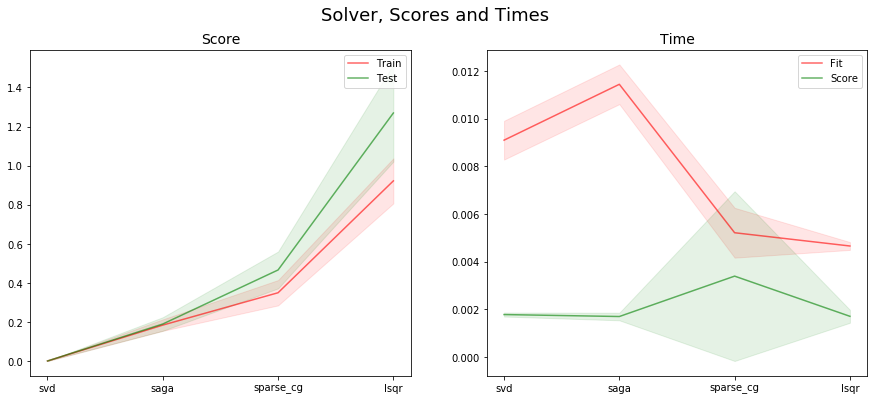

In [4]:
hyp.plot_hyperparameter(res[(res.param_ridge__alpha == 0) & (res.param_ridge__tol==0.001)], 'param_ridge__solver', 'Solver')

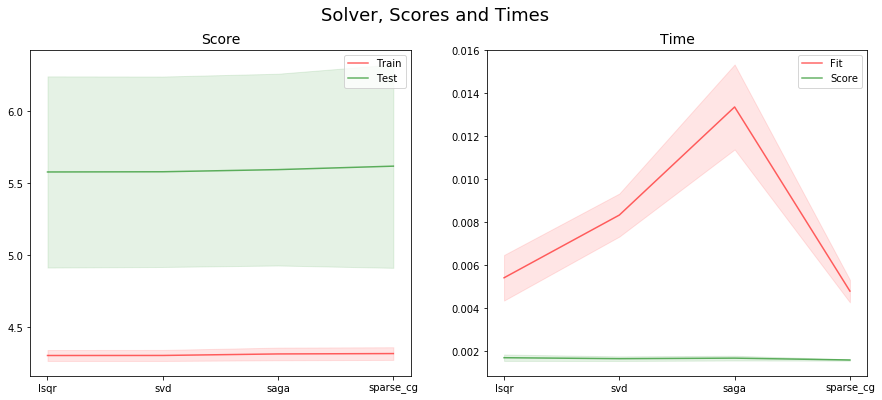

In [5]:
hyp.plot_hyperparameter(res[(res.param_ridge__alpha == 5) & (res.param_ridge__tol==0.001)], 'param_ridge__solver', 'Solver')

The setting `auto` for this hyperparameter will pick the best solver given the data so that we don't need to worry about it. It is still good to keep in mind that the performance is different.

The most important hyperparameter is `alpha`, the regularizing term. With this simple set of data we see that **more regularization leads to learning the training data less and less**, which is going to be true in almost every situation. In a sense, by introducing the regularization we want the model to learn less the training data so that it doesn't pick up too specific signals. For this particular set of data, however, we see that it also leads to a worse and worse performance on the test set, which is expected as we have seen in notebook 3 that the model was already perfoming very well.

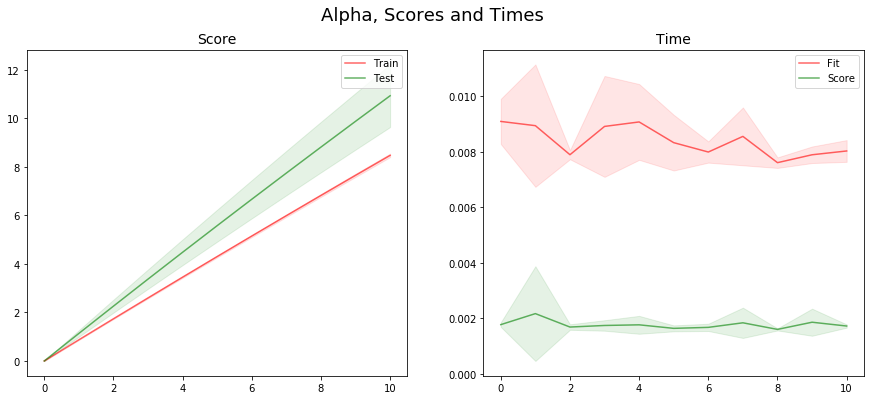

In [6]:
hyp.plot_hyperparameter(res[(res.param_ridge__solver=='svd') & (res.param_ridge__tol==0.001)], 'param_ridge__alpha', 'Alpha')

The last parameter is the tolerance and we can see in this joint plot that its importance is very limited, compared to the role of `alpha`.

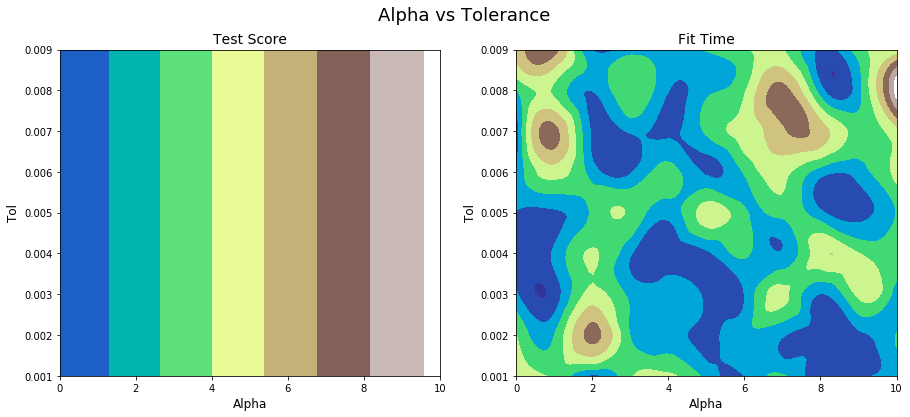

In [7]:
hyp.plot_two_hyperparms(res[(res.param_ridge__solver=='svd')], 'param_ridge__alpha', 'param_ridge__tol', 'Alpha vs Tolerance')

This first example is not very interesting, we have to recognize it, but we will see situations for which, either because the data are more complex, or because the set of features is peculiar, or because we have few training instances, that these hyperparameters will play a more important role. For example

In [8]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('ridge', Ridge(random_state=325))])

param_grid = {'ridge__alpha': list(np.arange(0, 100, 10)), 
              'ridge__tol': np.arange(0.001, 0.01, 0.001), 
              'ridge__solver': ['svd', 'sparse_cg', 'lsqr', 'saga']}

res = grid_results(model, kfolds, param_grid, target_name='tar_nonlin_10', sample=1000)

res.head()

{'ridge__alpha': 20, 'ridge__solver': 'sparse_cg', 'ridge__tol': 0.001}


param_ridge__alpha param_ridge__solver param_ridge__tol  mean_train_score  \
0                 20           sparse_cg            0.001        -12.371878   
1                 30                 svd            0.004        -12.348485   
2                 30                 svd            0.007        -12.348485   
3                 30                 svd            0.009        -12.348485   
4                 30                 svd            0.008        -12.348485   

   std_train_score  mean_test_score  std_test_score  mean_fit_time  \
0         0.123372       -13.854750        1.080658       0.009957   
1         0.120528       -13.871701        1.066752       0.015343   
2         0.120528       -13.871701        1.066752       0.013566   
3         0.120528       -13.871701        1.066752       0.015420   
4         0.120528       -13.871701        1.066752       0.013933   

   std_fit_time  mean_score_time  std_score_time  
0      0.000457         0.002068        0.000215  
1      0.001960         0.002710        0.001195  
2      0.000760         0.002577        0.001682  
3      0.001819         0.001987        0.000074  
4      0.000843         0.002250        0.000600

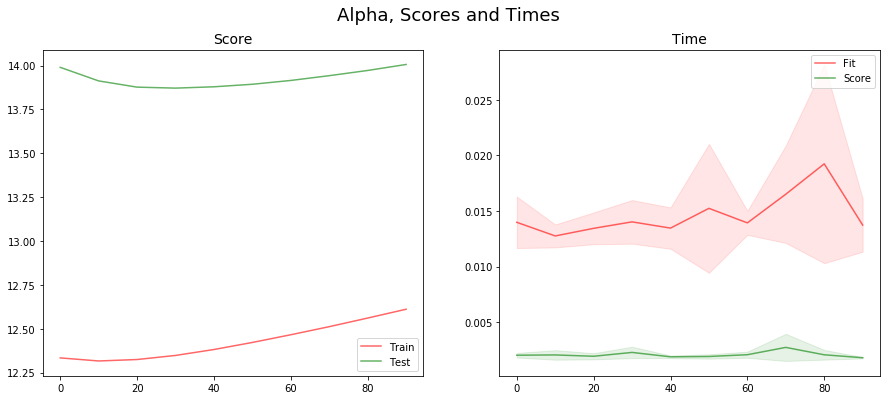

In [9]:
hyp.plot_hyperparameter(res[(res.param_ridge__solver=='svd') & (res.param_ridge__tol==0.001)], 'param_ridge__alpha', 'Alpha', uncertainty=False)

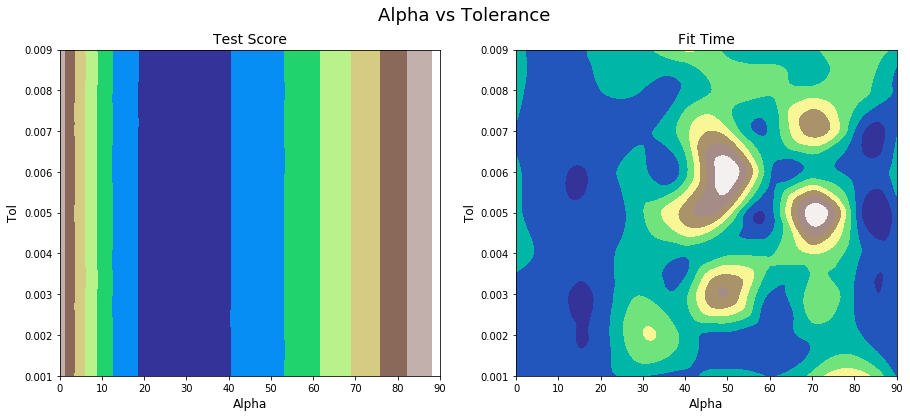

In [10]:
hyp.plot_two_hyperparms(res[(res.param_ridge__solver=='svd')], 'param_ridge__alpha', 'param_ridge__tol', 'Alpha vs Tolerance')

We again see that with more regularization the model learns less and less the training data, but also that in a certain range of values of `alpha` it gets a better score on the test set.

For the next experiments we will show every interesting pattern of this type.

# Noise and correlation

We can now repeat the previous experiments and observe how the algorithm is behaving differently even in the simplest case.

In [11]:
model = Pipeline([('imputer', df_p.df_imputer()), # everything assumes a 2 steps pipeline
                  ('ridge', Ridge())])
params = {'alpha': 1}

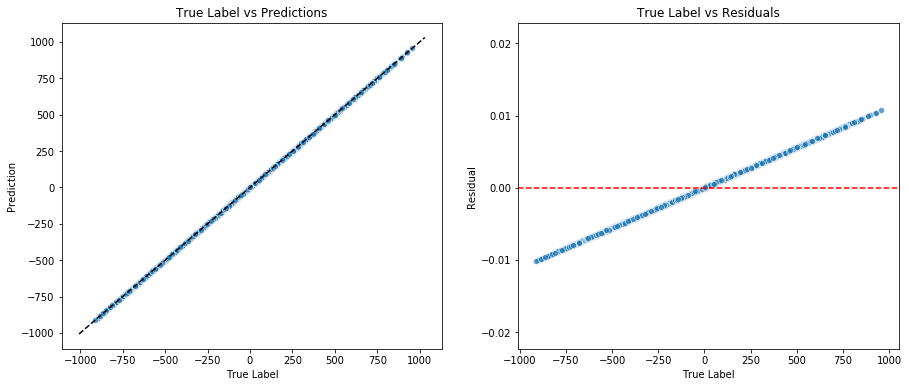

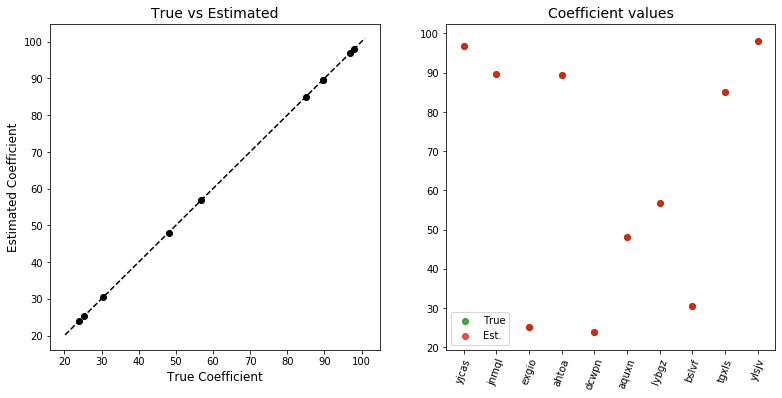

MAE: 		 0.00198
MSE: 		 1e-05
Max Error: 	 0.0107
Expl Variance: 	 1.0


In [12]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_nonoise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

While the coefficients are again estimated perfectly, the residuals show a pattern that suggests that the model is having more and more troubles in predicting larger (in the absolute sense) values of the target variable.

On the other hand, the predictions in the presence of noise and/or correlation are nearly identical

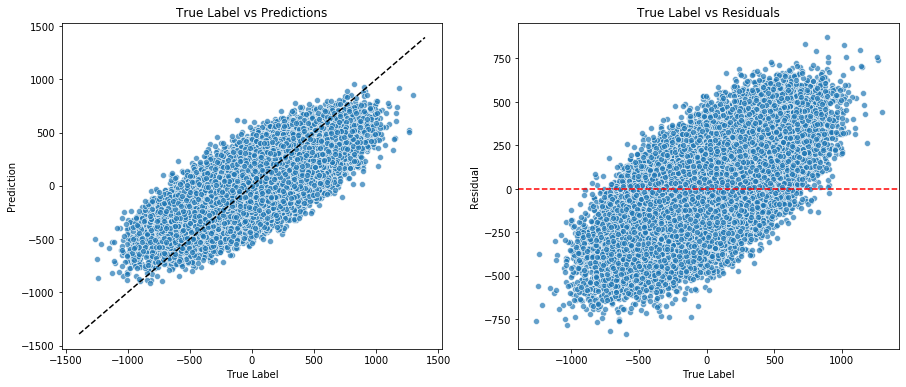

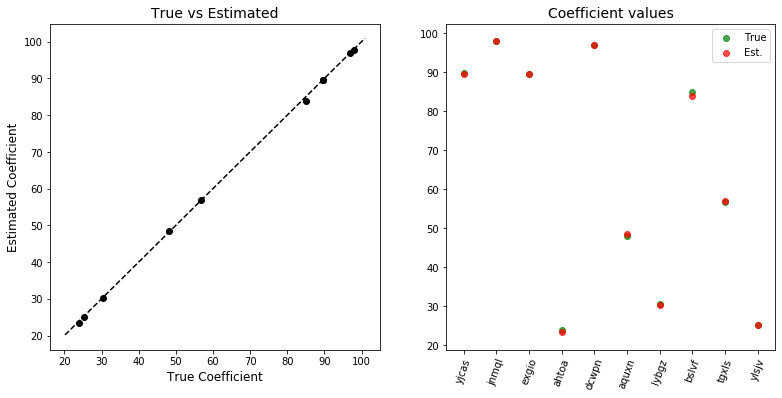

MAE: 		 159.15957
MSE: 		 39903.46366
Max Error: 	 870.78567
Expl Variance: 	 0.55337


In [13]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

Which is precisely the same result we got without the regularization

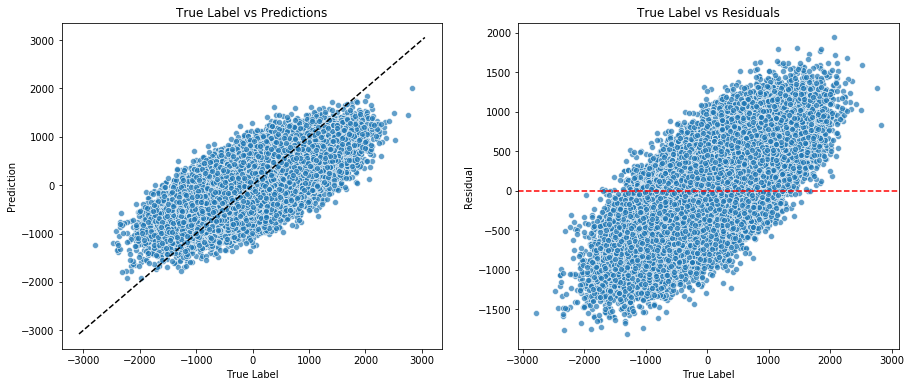

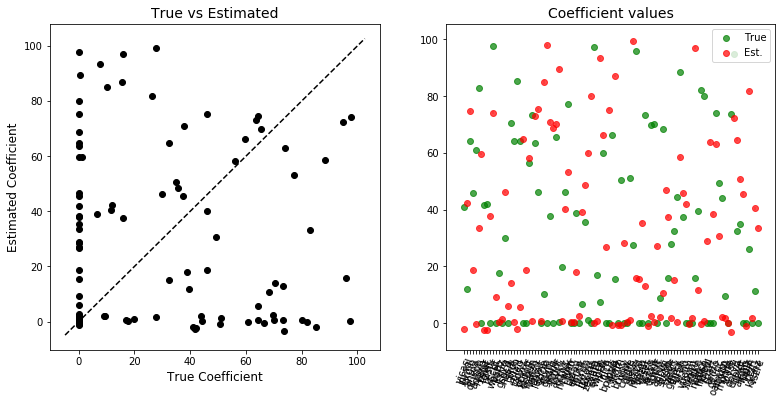

MAE: 		 359.51791
MSE: 		 202633.43736
Max Error: 	 1939.61387
Expl Variance: 	 0.48907


In [14]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/100_feat_65_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

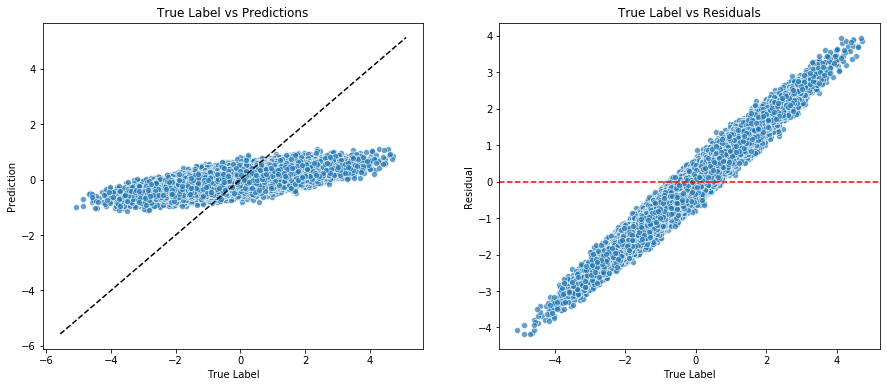

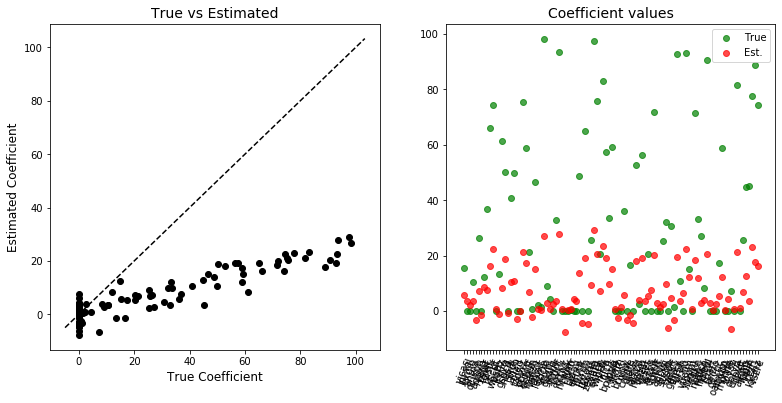

MAE: 		 0.79954
MSE: 		 1.00325
Max Error: 	 4.16769
Expl Variance: 	 0.26507


In [15]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/100_feat_65_inf_noise_rank.csv', 
         target_name=None, 
         features='all',
         sample=False, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

# Number of instances

The behavior is not changing much when we introduce the regularization. However, the solver is now chosen automatically given the features and this leads to faster training time. The training time still grows linearly, but with a lower rate of increase.

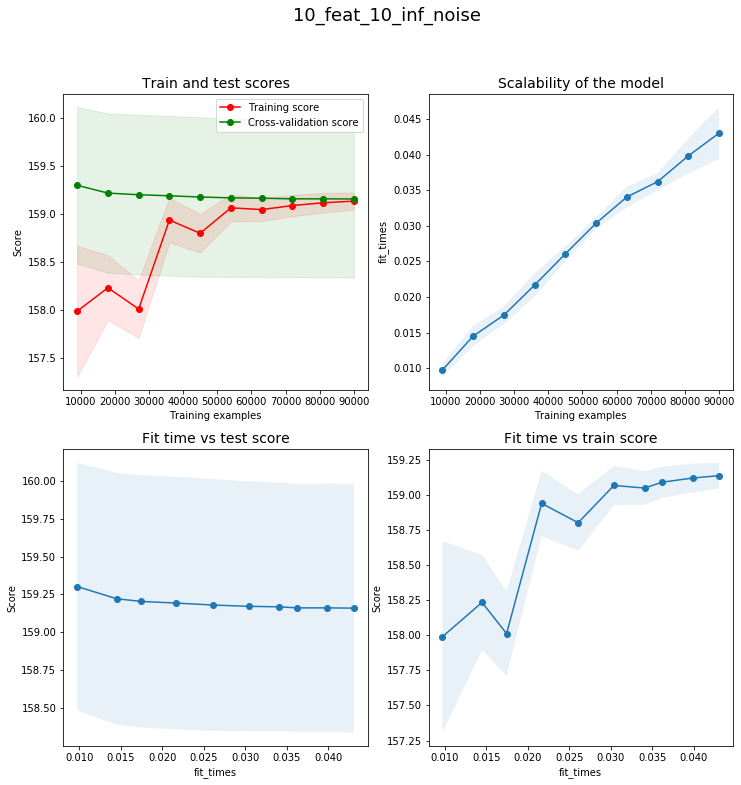

In [16]:
learning_curve(model=model, data_name='data/simulated/10_feat_10_inf_noise.csv', kfolds=kfolds)

For comparison, on the next set of data the fit time was going as high as 3 seconds, while now it is around 0.5 seconds.

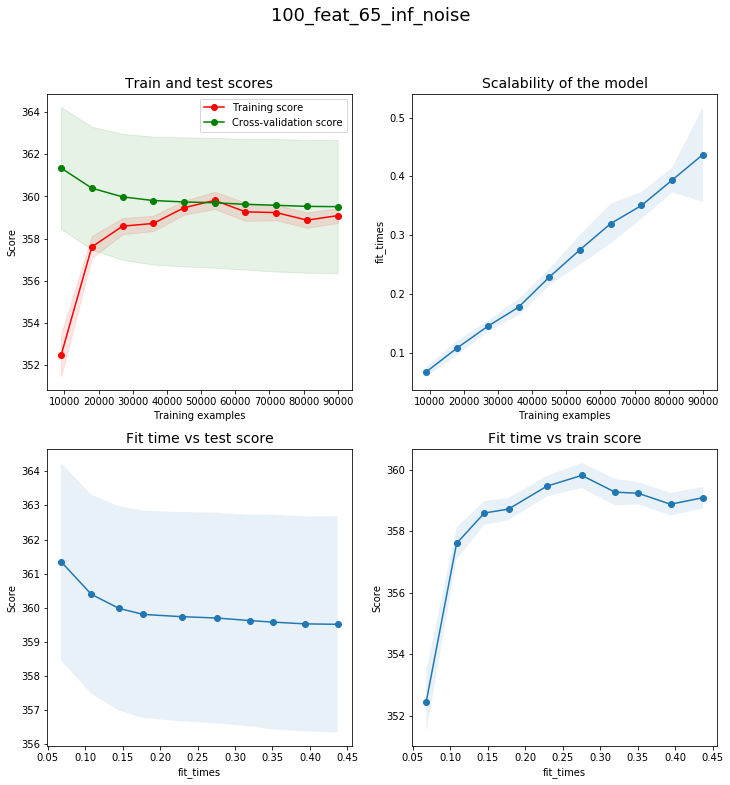

In [17]:
learning_curve(model=model, data_name='data/simulated/100_feat_65_inf_noise.csv', kfolds=kfolds)

It is important to keep in mind that the higher speed has nothing to do with the regularization introduced but rather with **a better implementation of the algorithm**. Therefore, if you ever need a faster version of `LinearRegression`, you could rely on `Ridge(alpha=0)`.


By reducing the number of training instances, we observe a less accurate set of predictions but still a good estimate of the coefficients

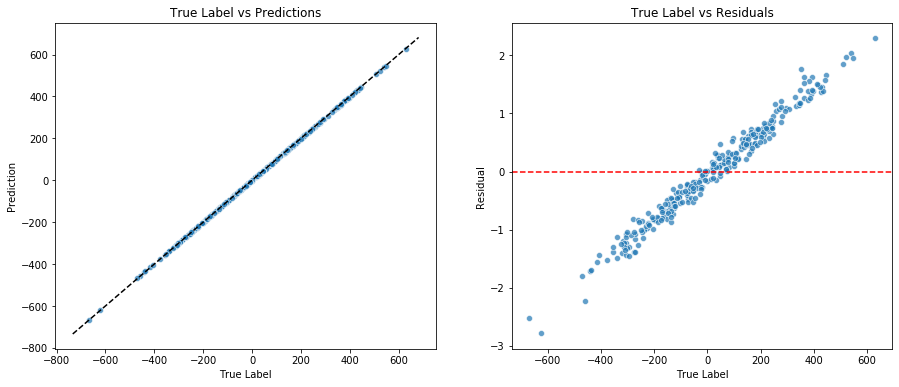

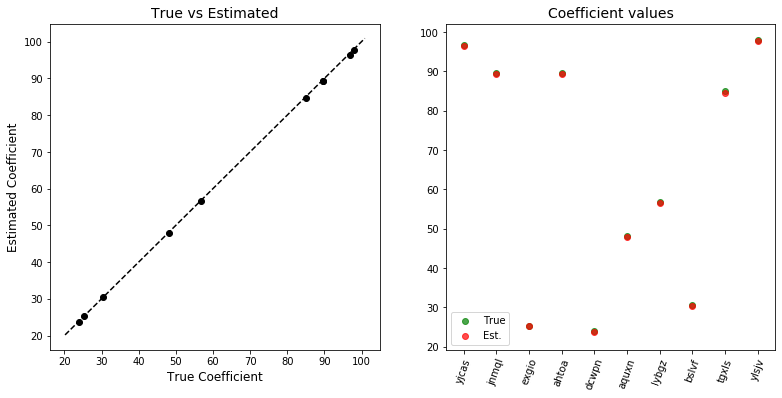

MAE: 		 0.70363
MSE: 		 0.74976
Max Error: 	 2.78554
Expl Variance: 	 0.99999


In [18]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_nonoise.csv', 
         target_name=None, 
         features='all',
         sample=300, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

It is worth noticing that, with this set of data of the next, the regularization is bringing to generally worse predictions in terms of mean absolute error and explained variance, but better results in terms of mean squared error and max error. Moreover, the estimates of the coefficients are arguably closer to their true values and we can give the merit to the regularizing term in the loss function.

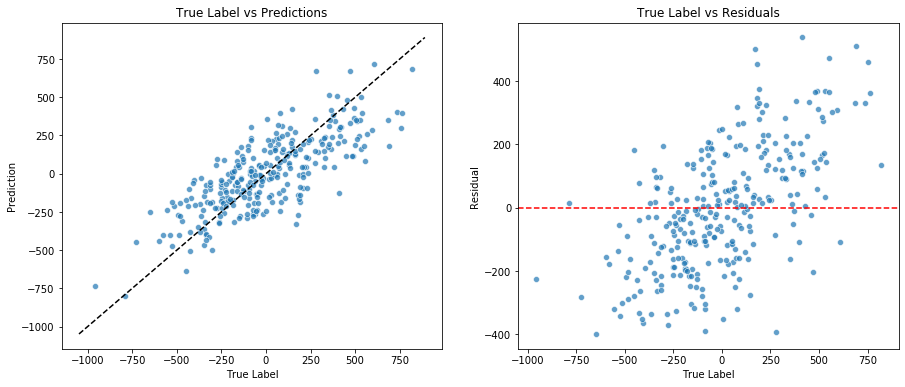

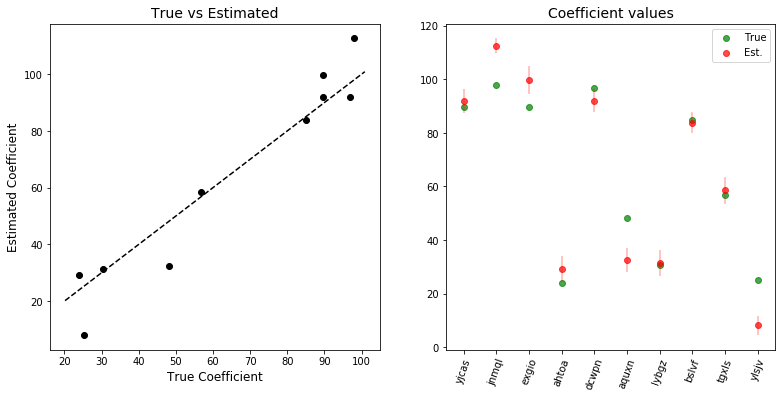

MAE: 		 156.15238
MSE: 		 37250.2161
Max Error: 	 537.39395
Expl Variance: 	 0.59855


In [19]:
make_exp(model=model, kfolds=kfolds, 
         data_name='data/simulated/10_feat_10_inf_noise.csv', 
         target_name=None, 
         features='all',
         sample=300, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

# More complex data

To observe more meaningful patterns, we turn out attention to a dataset with more complex relations.

## 100 features

As in the previous examples, the speed of the model is much higher (thanks to the better implementation) and we can again observe that the regularizing term is not influencing the ability of the model to be close to the best achievable result already with 9000 training samples.

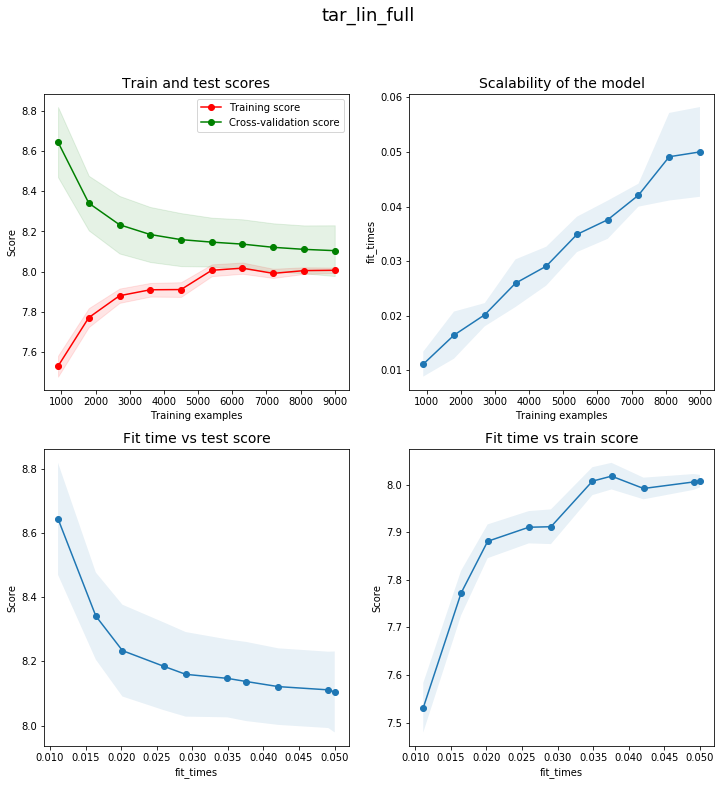

In [20]:
learning_curve(model, target_name='tar_lin_full', features='all', sample=10000, kfolds=kfolds)

When using all the features, we have seen in the previous notebook that the model was generally underestimating the coefficients, a pattern that is not as evident now with the regularizing term.

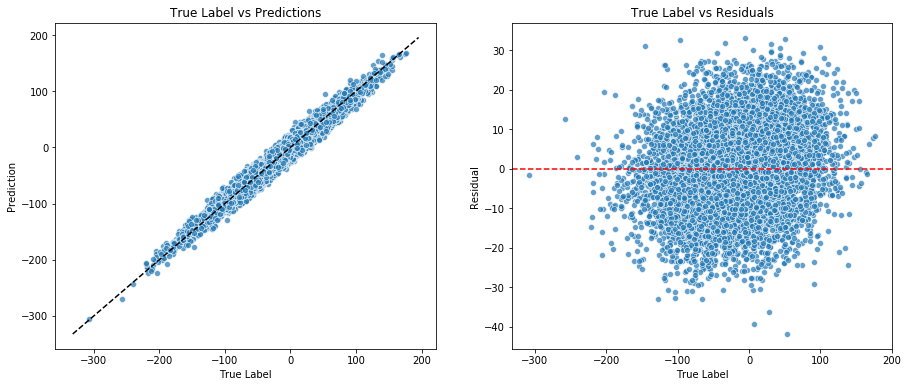

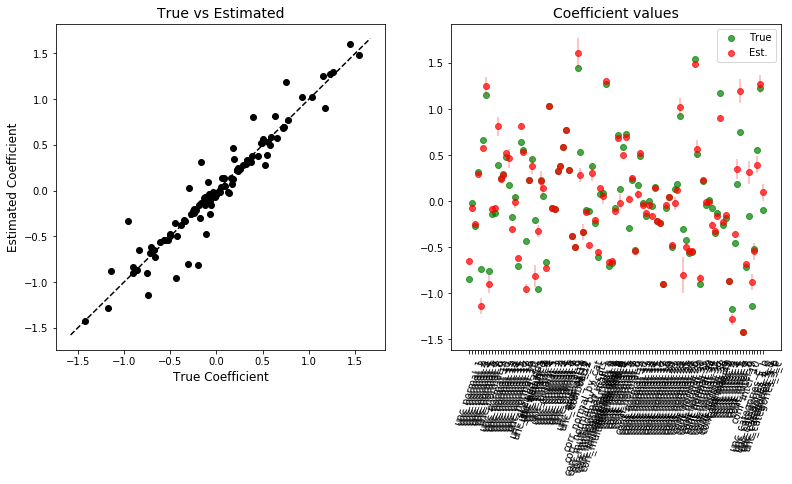

MAE: 		 8.03609
MSE: 		 101.71021
Max Error: 	 41.83704
Expl Variance: 	 0.96916


In [21]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

However, we can't help but notice that the model is not performing better than before.

On the other hand, when reducing the number of training instances the drop in performance is much smaller than before.

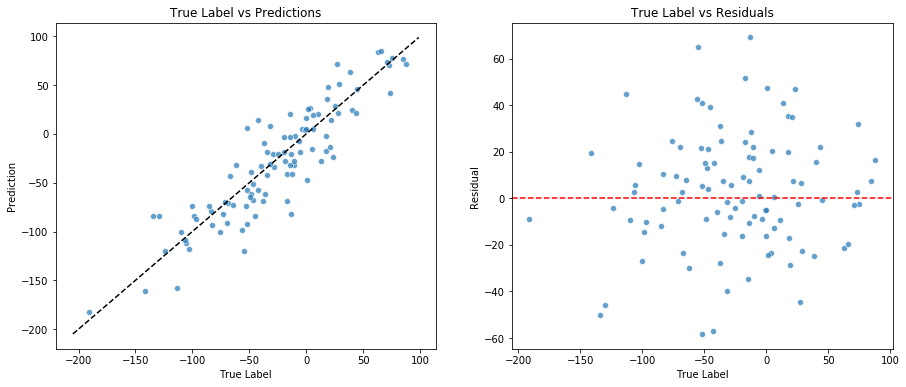

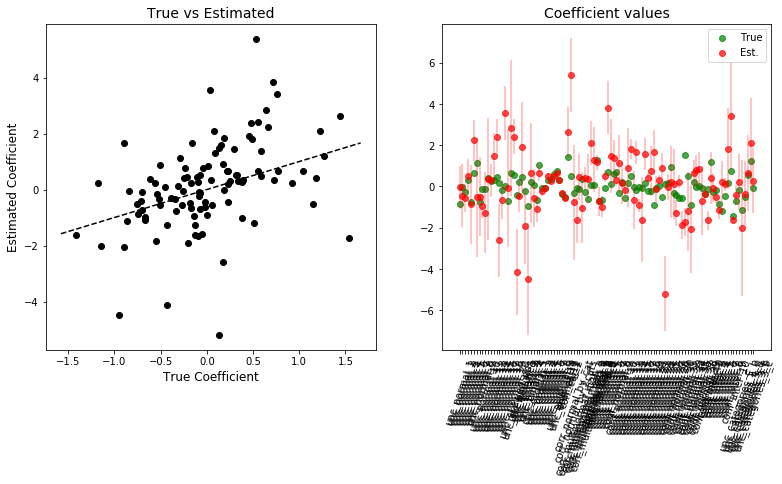

MAE: 		 19.64985
MSE: 		 637.47834
Max Error: 	 69.14485
Expl Variance: 	 0.78636


In [22]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='all',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

This suggests that **the regularization is somewhat helping** and we indeed see that increasing it leads to a better performing model. This can be seen in the following plot.

{'ridge__alpha': 39}


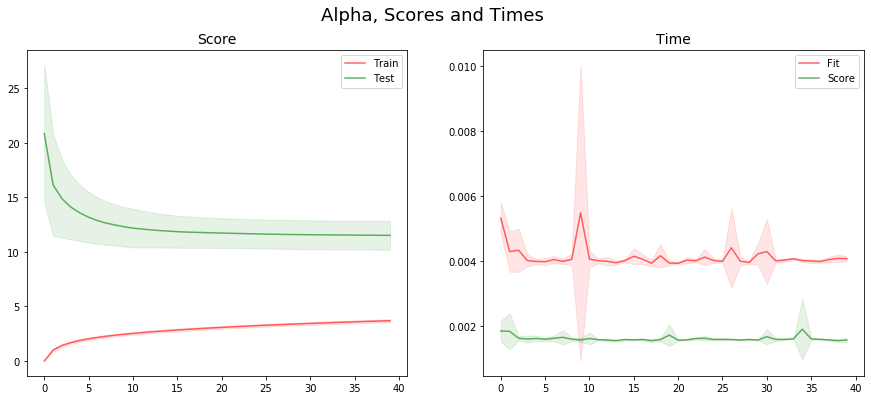

In [23]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('ridge', Ridge(random_state=325))])

param_grid = {'ridge__alpha': list(np.arange(0, 40, 1))}

res = grid_results(model, kfolds, param_grid, target_name='tar_lin_full', sample=100)

hyp.plot_hyperparameter(res, 'param_ridge__alpha', 'Alpha')

And we can indeed see a better perfoming model already with `alpha=20`

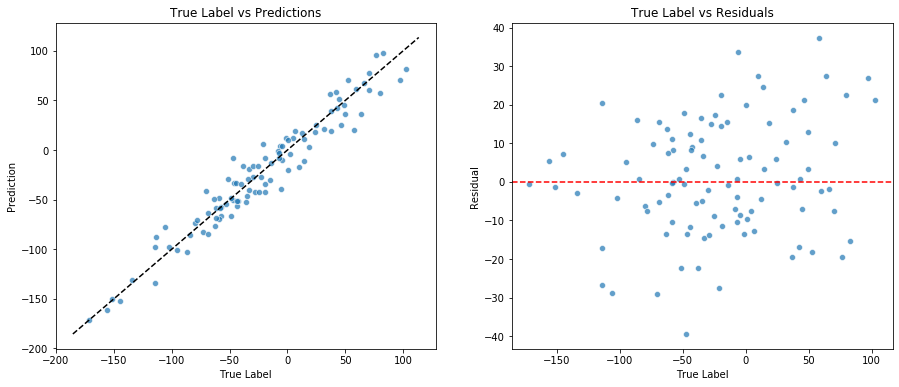

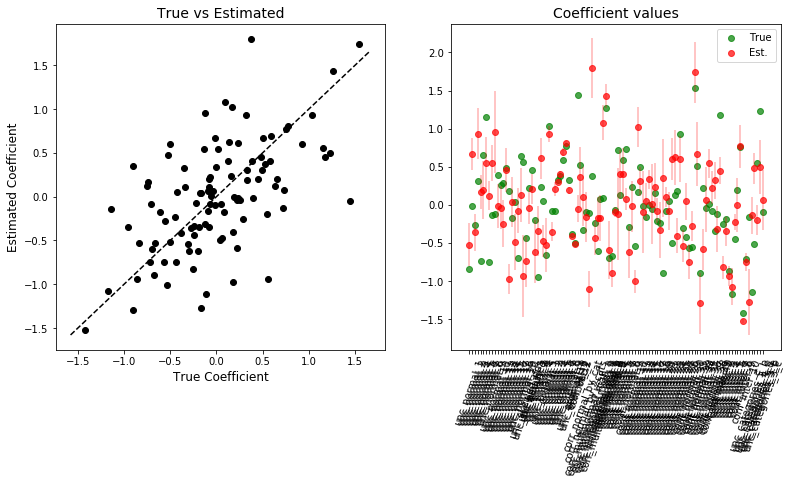

MAE: 		 11.96653
MSE: 		 223.23236
Max Error: 	 39.40315
Expl Variance: 	 0.93538


In [24]:
model = Pipeline([('imputer', df_p.df_imputer()), # everything assumes a 2 steps pipeline
                  ('ridge', Ridge(alpha=20))])
params = {'alpha': 20}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='all',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

In the presence of **unobserved variables**, however, the model struggles and start to present some large errors in the cefficients' estimates. Playing with the regularization does not seem to help

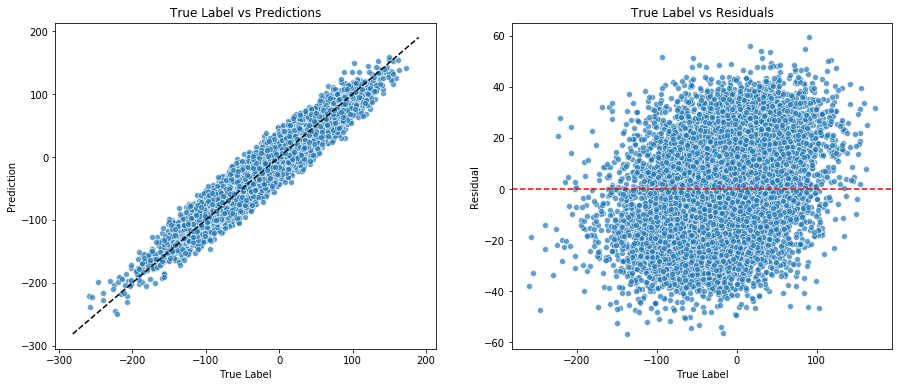

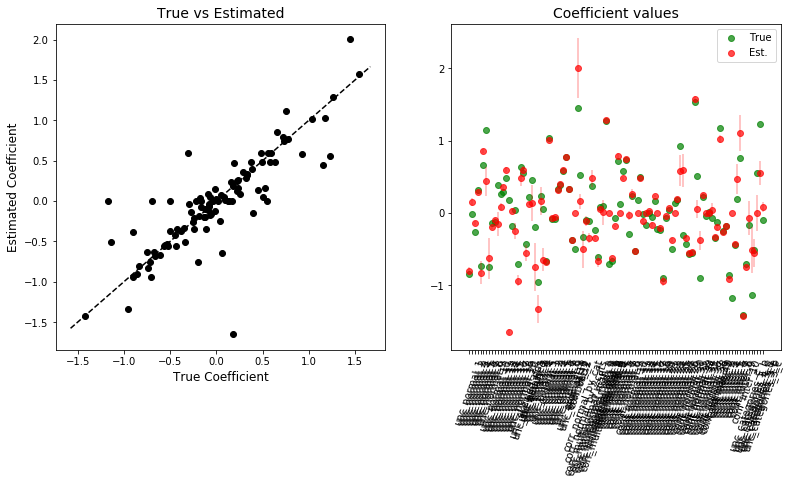

MAE: 		 15.70143
MSE: 		 359.67875
Max Error: 	 59.24546
Expl Variance: 	 0.89358


In [25]:
model = Pipeline([('imputer', df_p.df_imputer()), # everything assumes a 2 steps pipeline
                  ('ridge', Ridge(alpha=1))])
params = {'alpha': 1}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_full', 
         features='unobserved',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

## 50 features

Let's now turn our attention to a situation where only 50 features of the 100 available have been used to generate the target

In [26]:
model = Pipeline([('imputer', df_p.df_imputer()), # everything assumes a 2 steps pipeline
                  ('ridge', Ridge(alpha=1))])
params = {'alpha': 1}

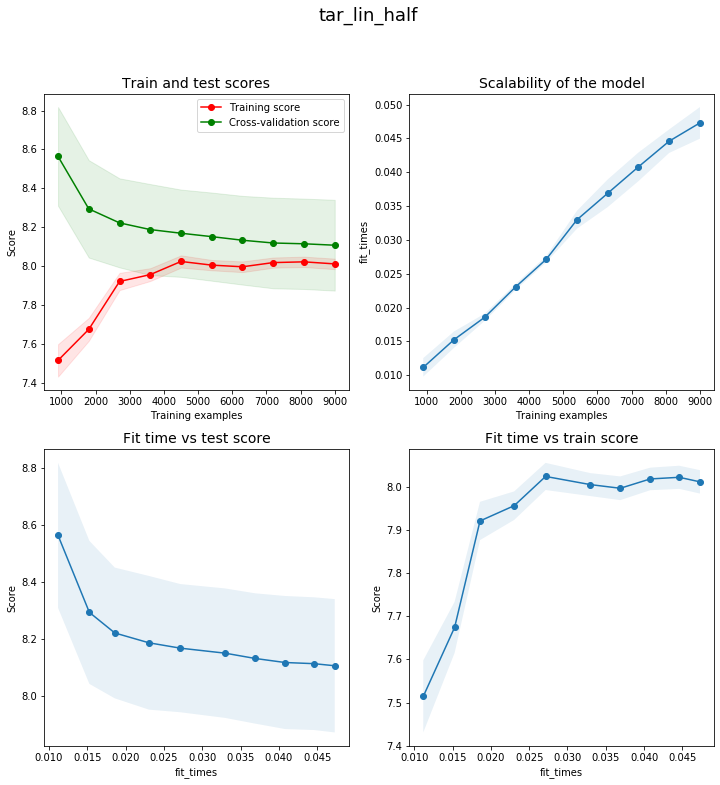

In [27]:
learning_curve(model, target_name='tar_lin_half', features='all', sample=10000, kfolds=kfolds)

We can also appreciate how faster and more accurate the model becomes when we use the exact features we need to predict the target

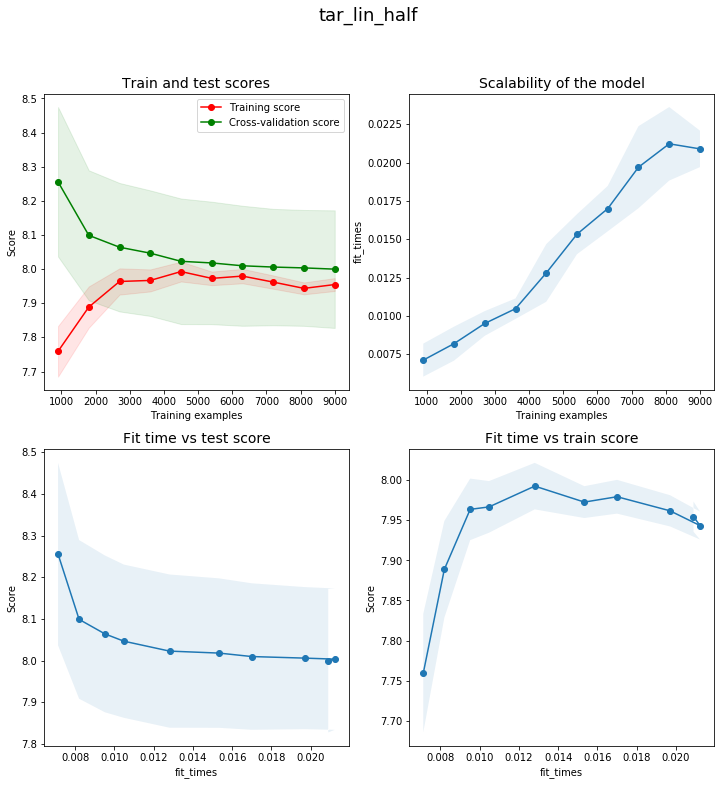

In [28]:
learning_curve(model, target_name='tar_lin_half', features='exact', sample=10000, kfolds=kfolds)

We can thus use this as baseline for the next set of experiments. The performance is nearly identical with or without the regularization

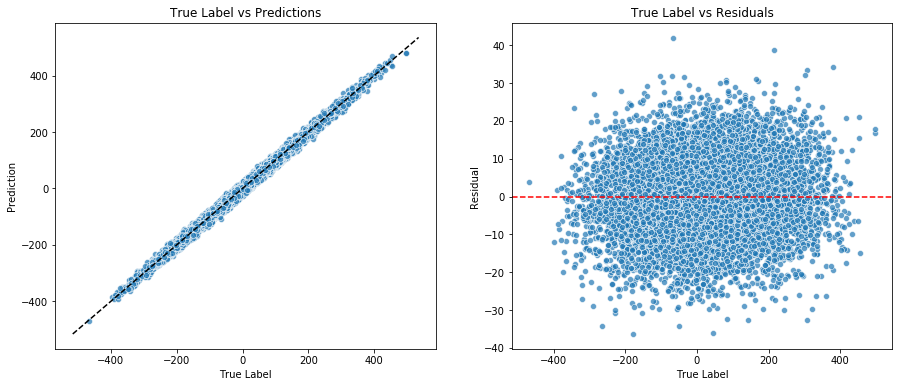

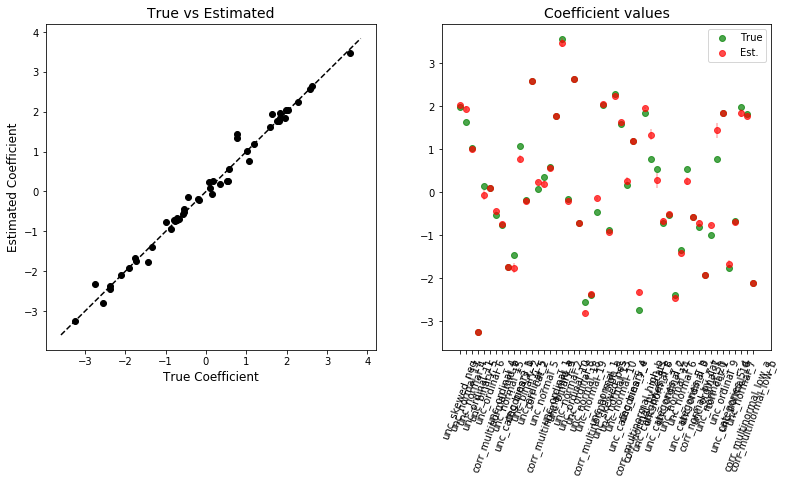

MAE: 		 7.97958
MSE: 		 99.72829
Max Error: 	 42.04302
Expl Variance: 	 0.9955


In [29]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

Predictably, reducing the number of training instances leads to a worse performing model but, this time, it is performing better than its non-regularized counterpart

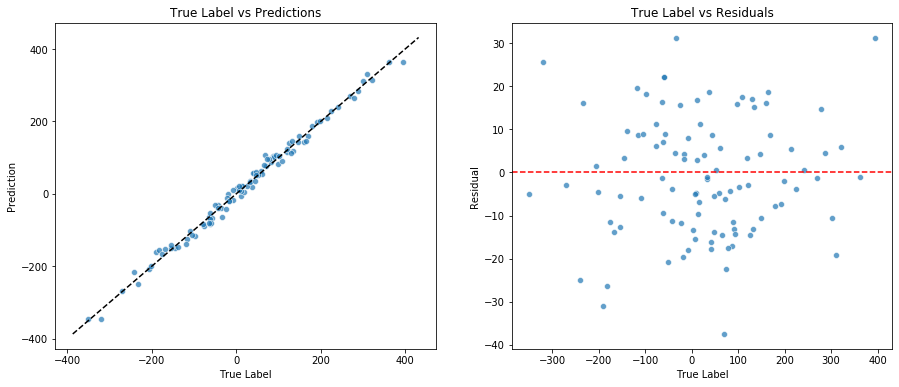

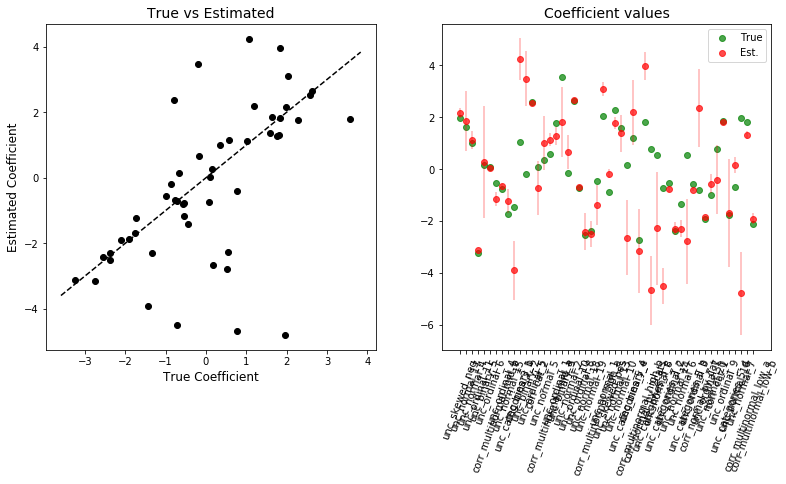

MAE: 		 11.34418
MSE: 		 190.35972
Max Error: 	 37.53532
Expl Variance: 	 0.9913


In [30]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

We can again search of the best configuration

{'ridge__alpha': 11}


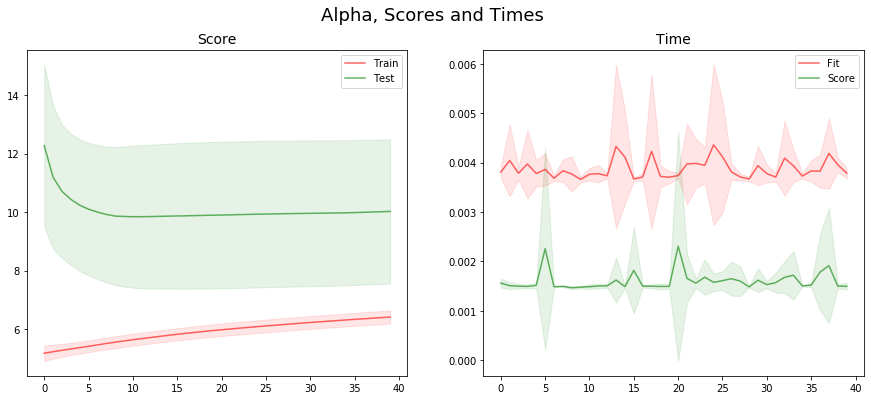

In [31]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('ridge', Ridge(random_state=325))])

param_grid = {'ridge__alpha': list(np.arange(0, 40, 1))}

res = grid_results(model, kfolds, param_grid, target_name='tar_lin_half', sample=100, features='exact')

hyp.plot_hyperparameter(res, 'param_ridge__alpha', 'Alpha')

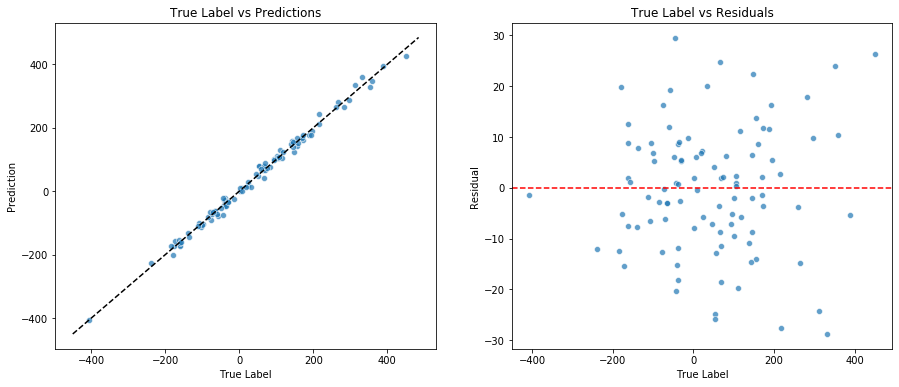

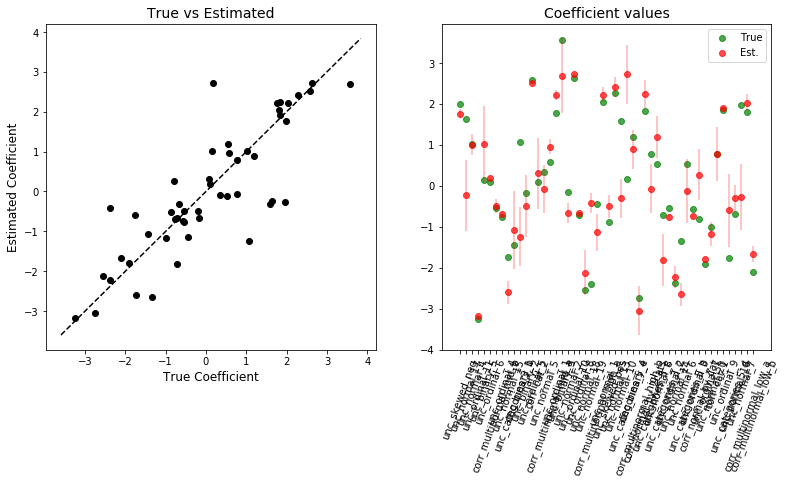

MAE: 		 9.83524
MSE: 		 152.51366
Max Error: 	 29.56273
Expl Variance: 	 0.99328


In [32]:
model = Pipeline([('imputer', df_p.df_imputer()), # everything assumes a 2 steps pipeline
                  ('ridge', Ridge(alpha=6))])
params = {'alpha': 6}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

Which is not really better than before, teaching us the valuable lesson that **tuning your model for a small improvement can do more harm than good**. Especially if the uncertainty is so large.

Training the model on more features than necessary doesn't seem to influence the performance or the coefficients' estimates much.

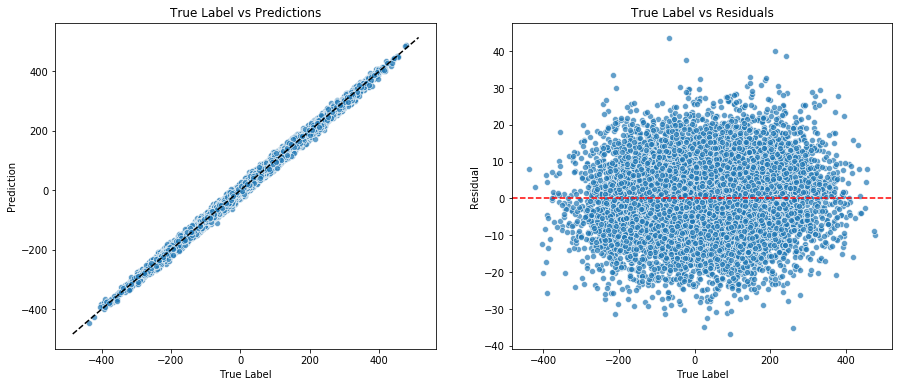

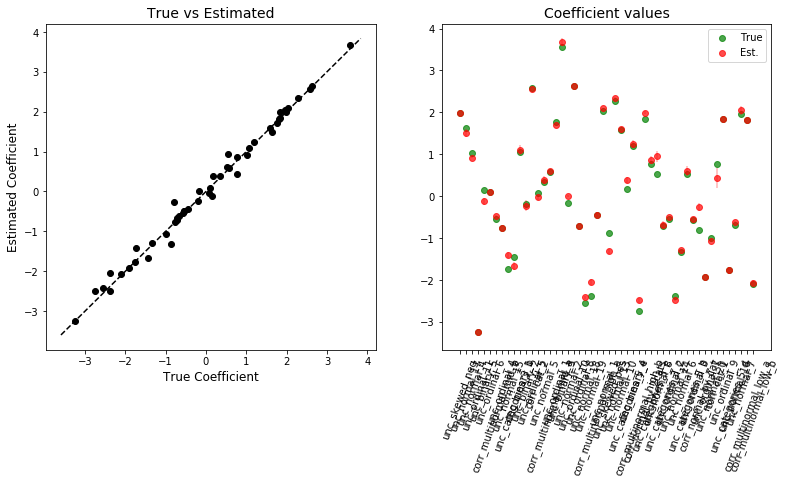

MAE: 		 7.91533
MSE: 		 98.3119
Max Error: 	 43.72433
Expl Variance: 	 0.99547


In [33]:
model = Pipeline([('imputer', df_p.df_imputer()), # everything assumes a 2 steps pipeline
                  ('ridge', Ridge(alpha=1))])
params = {'alpha': 1}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

But again the drop in performance that one expects when the number of training instances is reduced is somewhat smaller thanks to the regularization. The reason is that the model is not giving too much importance to one feature due to the limited sample thanks to the fact that the magnitude of the coefficients is regularized by the term *alpha*.

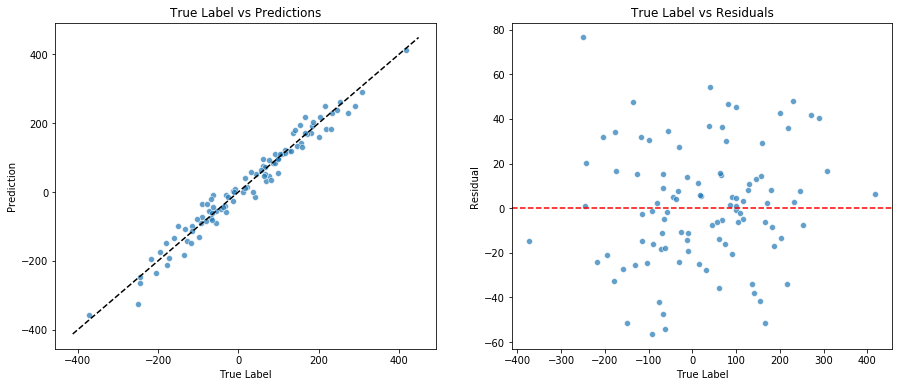

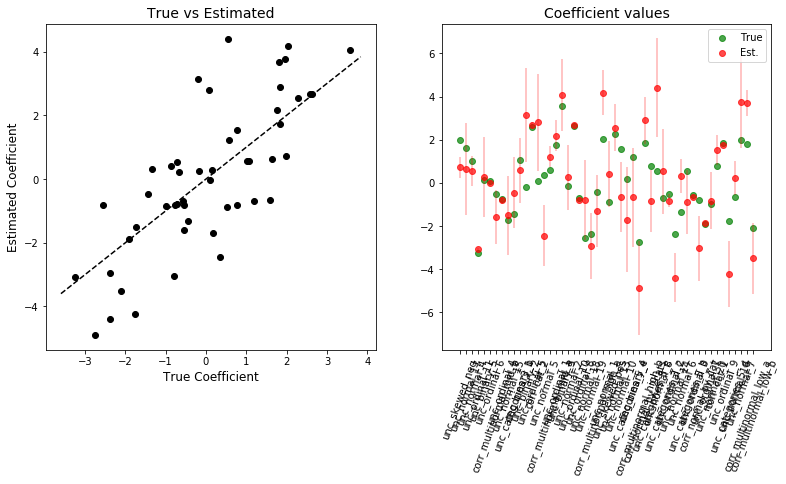

MAE: 		 20.82447
MSE: 		 700.81025
Max Error: 	 76.44102
Expl Variance: 	 0.96636


In [34]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='all',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

{'ridge__alpha': 39}


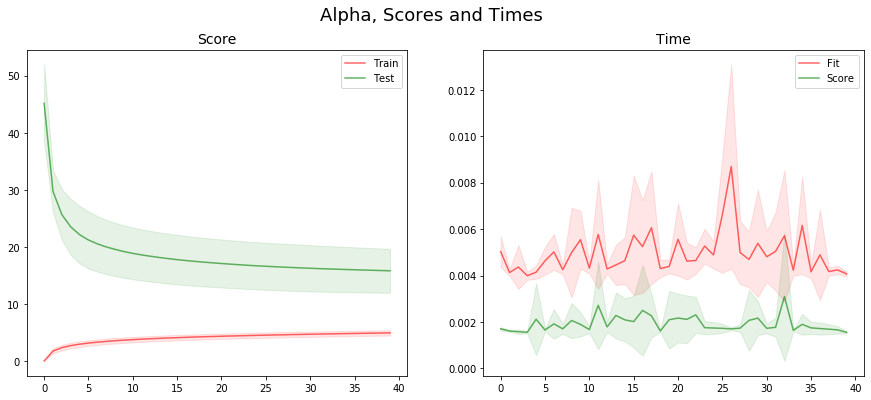

In [35]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('ridge', Ridge(random_state=325))])

param_grid = {'ridge__alpha': list(np.arange(0, 40, 1))}

res = grid_results(model, kfolds, param_grid, target_name='tar_lin_half', sample=100)

hyp.plot_hyperparameter(res, 'param_ridge__alpha', 'Alpha')

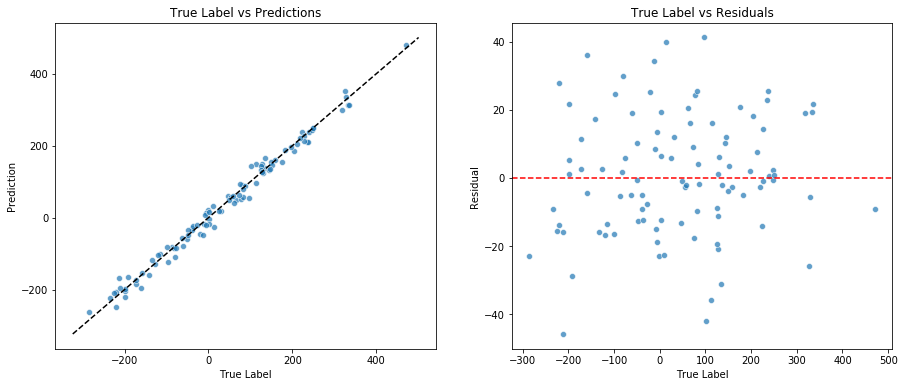

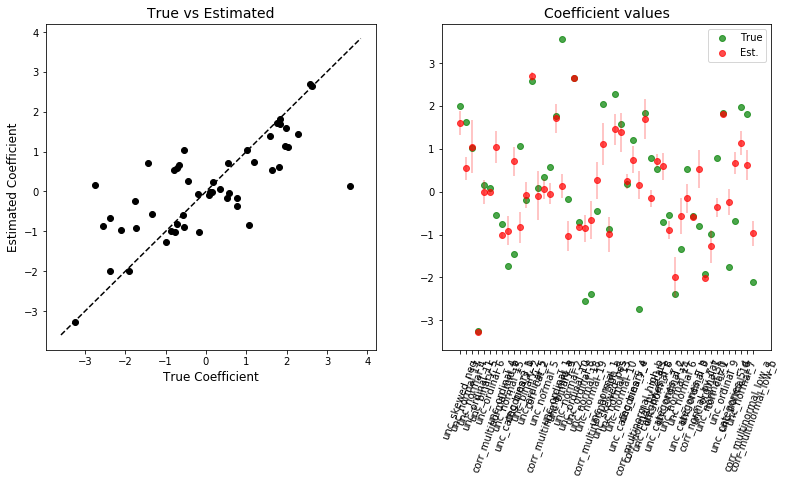

MAE: 		 14.05324
MSE: 		 311.79546
Max Error: 	 45.80412
Expl Variance: 	 0.98755


In [36]:
model = Pipeline([('imputer', df_p.df_imputer()), # everything assumes a 2 steps pipeline
                  ('ridge', Ridge(alpha=20))])
params = {'alpha': 20}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='all',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

We indeed improved the performance and the coefficients' estimates are less all over the place. Intuitively, it makes sense that the regularization is helping now as it should help handling better features that are not supposed to be important for predicting the target (and in this case half of the features are not relevant).

On the other hand, when it is a certain number of features missing, the regularization does not seem to help much.

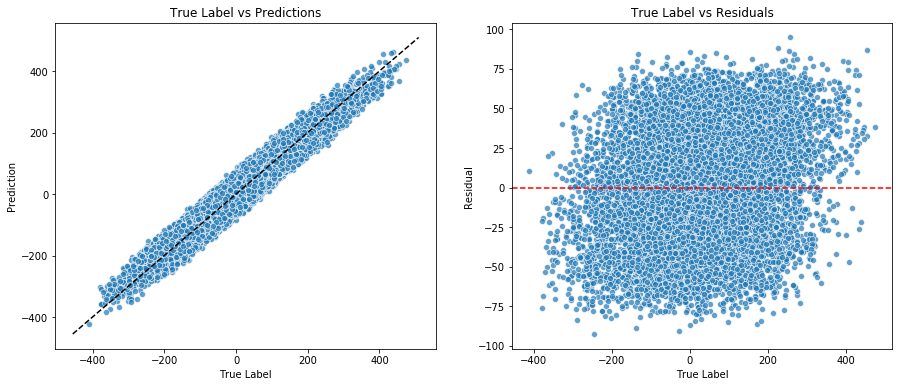

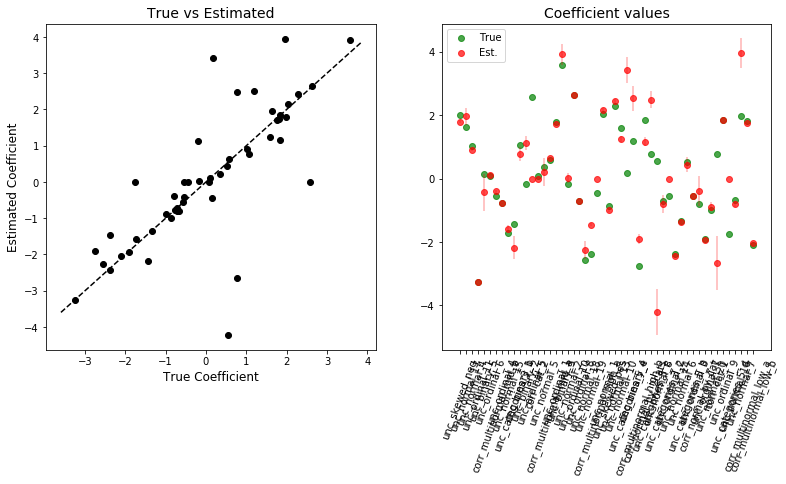

MAE: 		 32.35179
MSE: 		 1433.86367
Max Error: 	 94.86319
Expl Variance: 	 0.93447


In [37]:
model = Pipeline([('imputer', df_p.df_imputer()), # everything assumes a 2 steps pipeline
                  ('ridge', Ridge(alpha=1))])
params = {'alpha': 1}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='exact-10',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

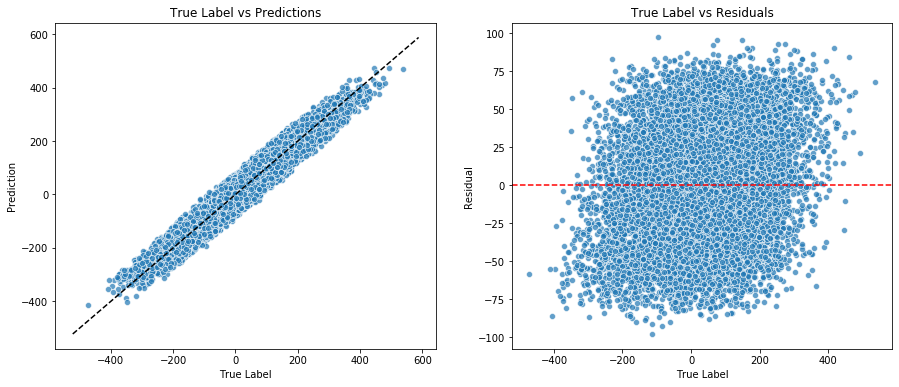

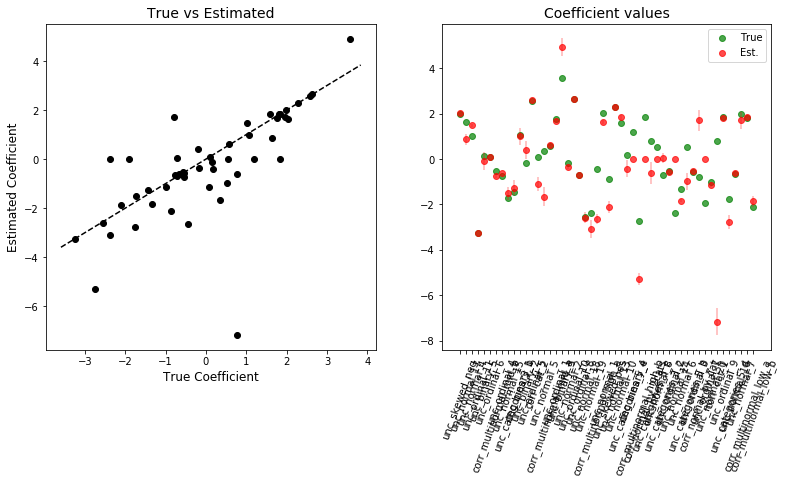

MAE: 		 33.89543
MSE: 		 1580.42571
Max Error: 	 97.96027
Expl Variance: 	 0.92755


In [38]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_half', 
         features='unobserved',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

## 10 features

We have already seen how easy it is for the model to pick up the signal from the data. Introducing a regularization term is helping in slighly improving the metrics.

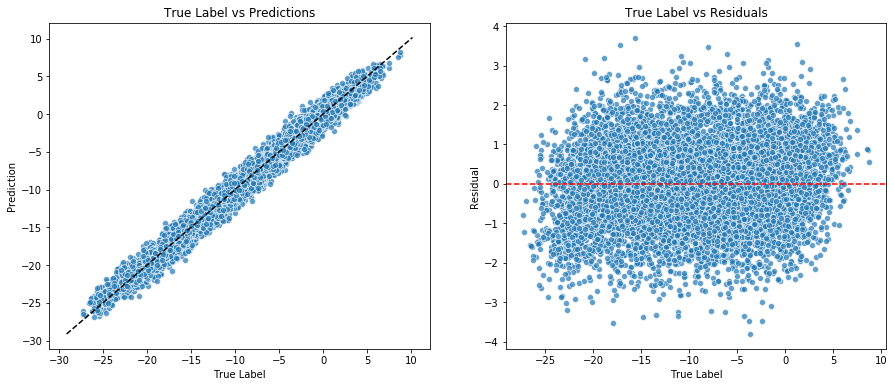

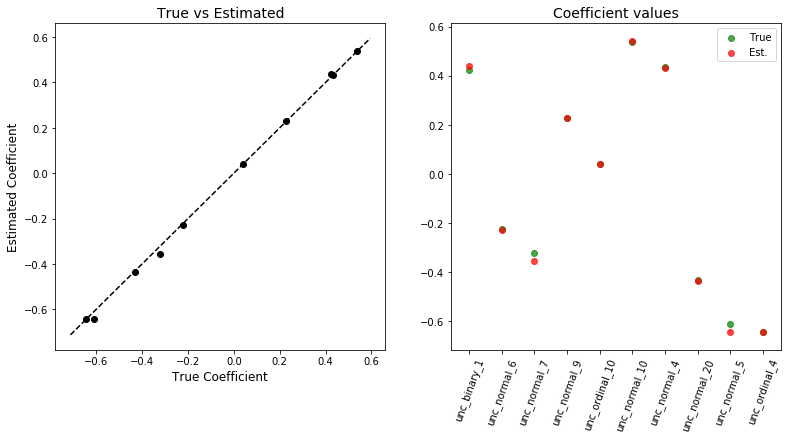

MAE: 		 0.79981
MSE: 		 1.00773
Max Error: 	 3.79828
Expl Variance: 	 0.98236


In [39]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='exact',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

We can also see how the performance gets worse if we reduce the training instances to 100. In particular, we see 2 coefficients wrongly estimated quite significantly.

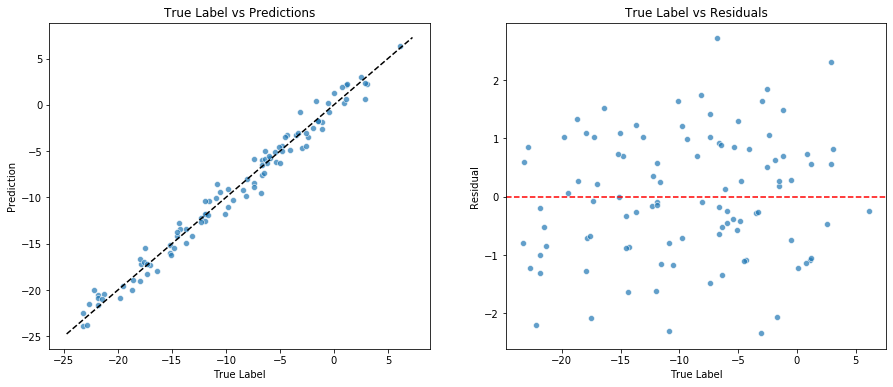

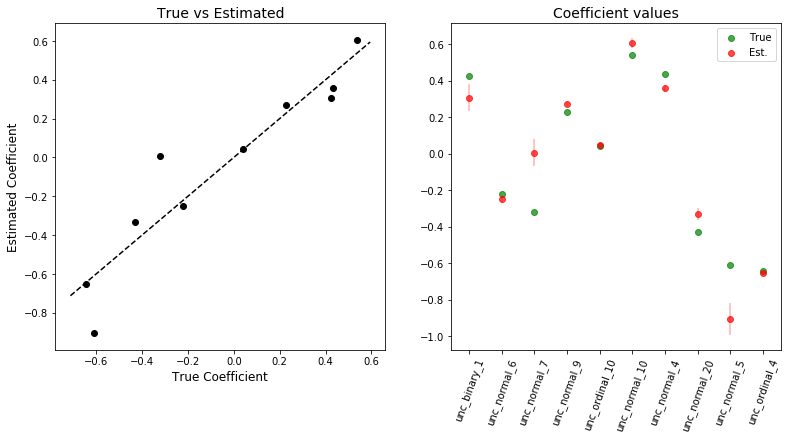

MAE: 		 0.88547
MSE: 		 1.13292
Max Error: 	 2.72034
Expl Variance: 	 0.97965


In [40]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='exact',
         sample=100, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

On the other hand, using more features or fewer features than necessary doesn't seem to compromise the model behavior much.

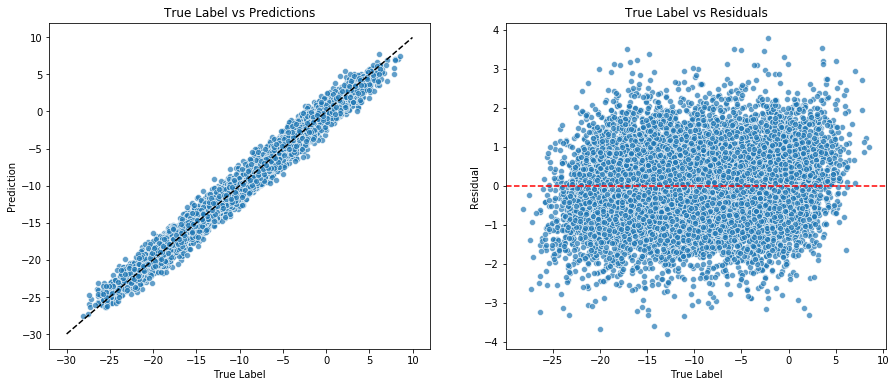

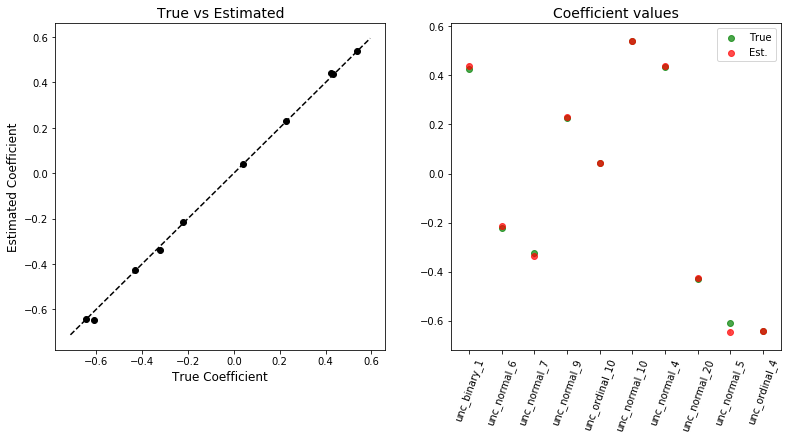

MAE: 		 0.79796
MSE: 		 0.99734
Max Error: 	 3.79375
Expl Variance: 	 0.9822


In [41]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='all',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

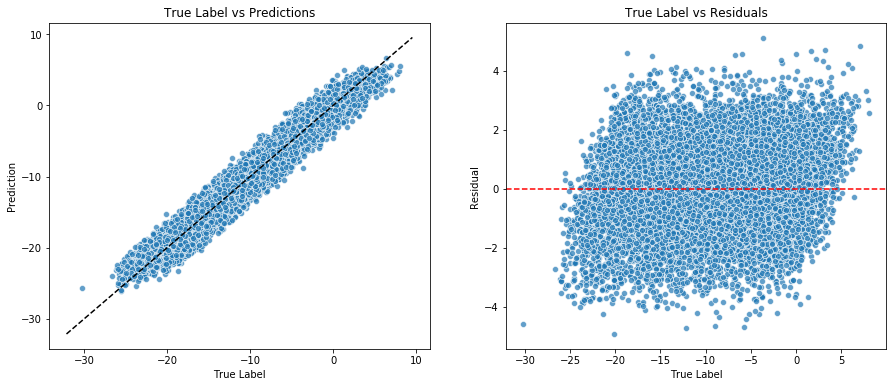

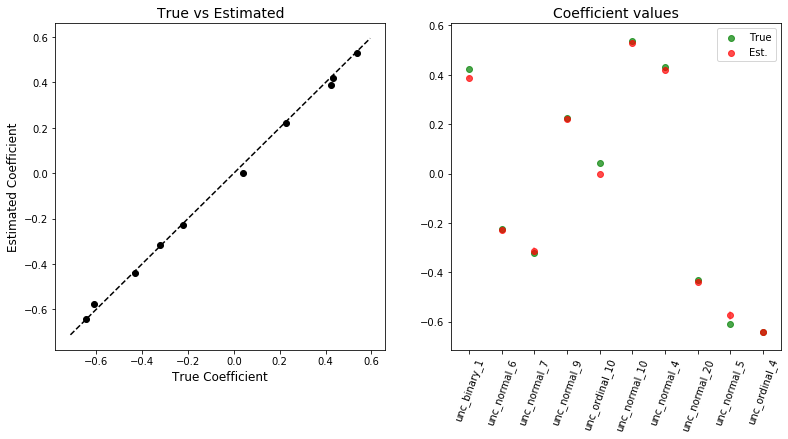

MAE: 		 1.27112
MSE: 		 2.42533
Max Error: 	 5.12048
Expl Variance: 	 0.95724


In [42]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='exact-10',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

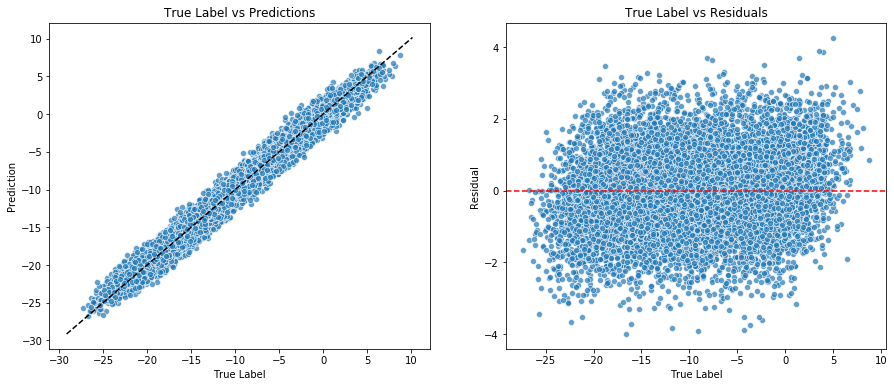

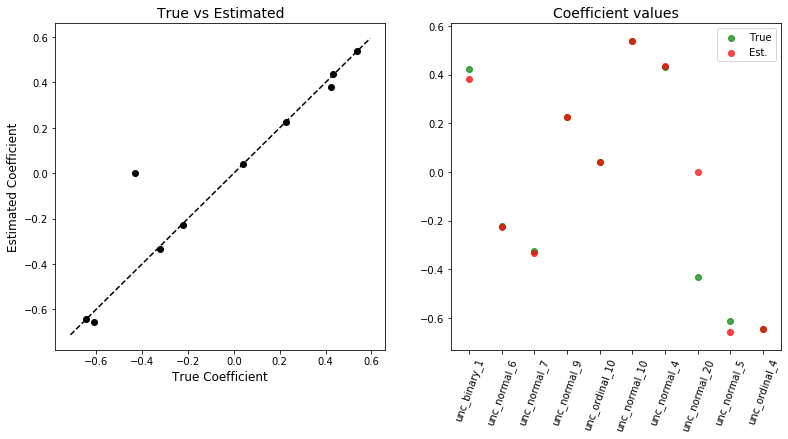

MAE: 		 0.90434
MSE: 		 1.27879
Max Error: 	 4.25418
Expl Variance: 	 0.97703


In [43]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_lin_10', 
         features='unobserved',
         sample=10000, 
         store=True, coefs=True, store_name=lab_book, parameters=params, model_name=modelname)

## Non-linear relations

Using a target generated non-linearly we expect the model to struggle in finding the right signal. As we have seen in notebook 3, it is not the case but introducing the regularization is slightly improving the evaluation metrics.

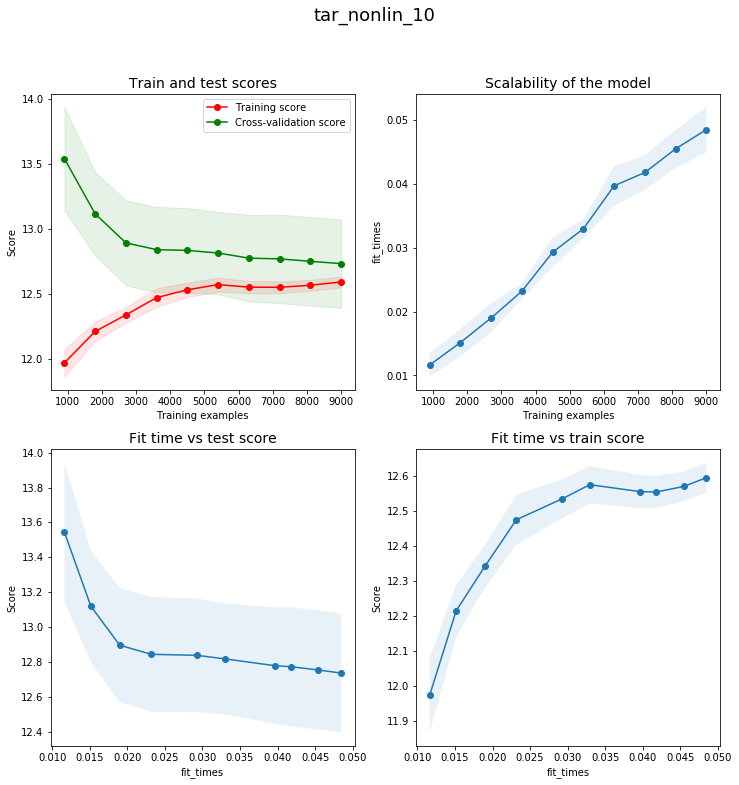

In [44]:
learning_curve(model, target_name='tar_nonlin_10', features='all', sample=10000, kfolds=kfolds)

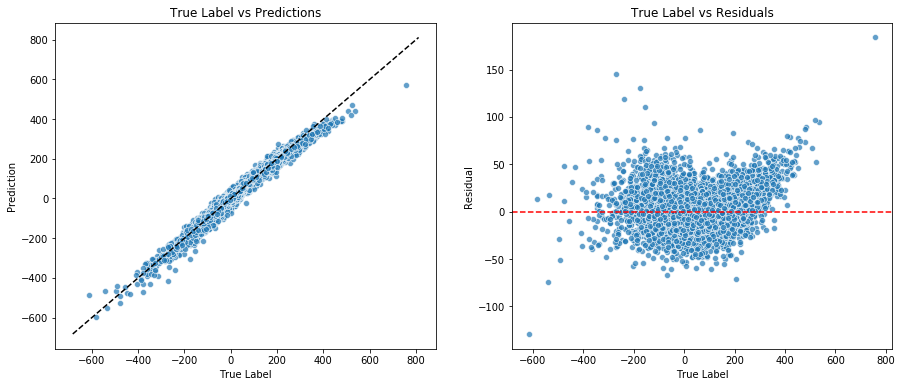

MAE: 		 12.73226
MSE: 		 302.78865
Max Error: 	 183.7948
Expl Variance: 	 0.97971


In [45]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_nonlin_10', 
         features='all',
         sample=10000, 
         store=True, coefs=False, store_name=lab_book, parameters=params, model_name=modelname)

Once again, reducing the number of observations leads to a worse performance but, once again, it is this the situation where the regularization is helpful the most

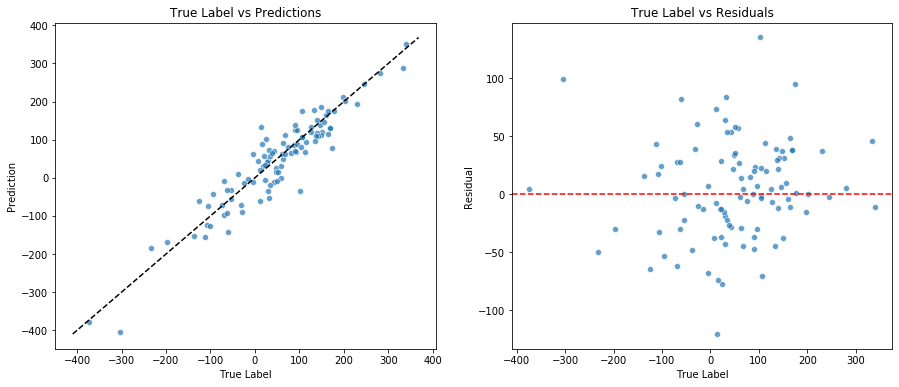

MAE: 		 33.05181
MSE: 		 1805.65085
Max Error: 	 135.23519
Expl Variance: 	 0.86882


In [46]:
make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_nonlin_10', 
         features='all',
         sample=100, 
         store=True, coefs=False, store_name=lab_book, parameters=params, model_name=modelname)

{'ridge__alpha': 6.0}


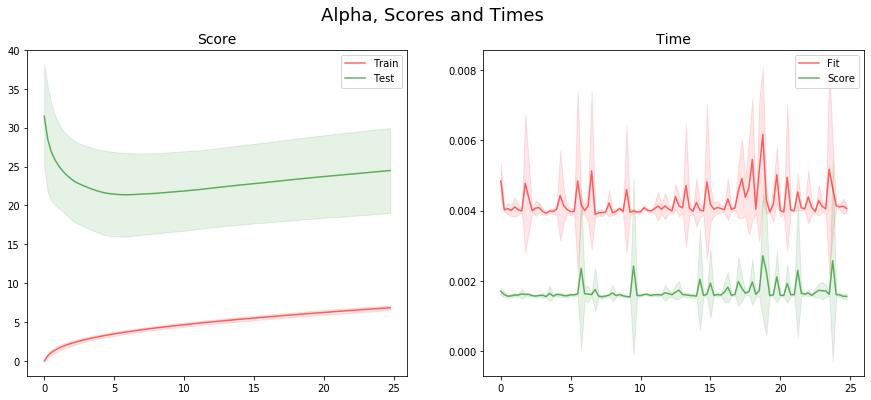

In [47]:
model = Pipeline([('imputer', df_p.df_imputer()), 
                  ('ridge', Ridge(random_state=325))])

param_grid = {'ridge__alpha': list(np.arange(0, 25, 0.25))}

res = grid_results(model, kfolds, param_grid, target_name='tar_nonlin_10', sample=100, features='all')

hyp.plot_hyperparameter(res, 'param_ridge__alpha', 'Alpha')

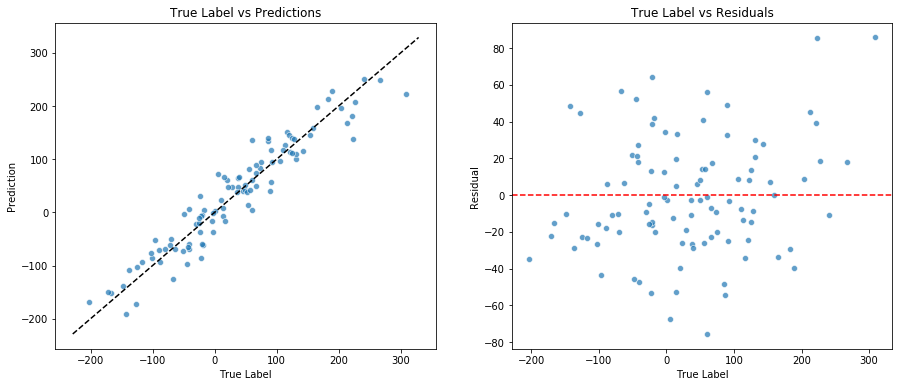

MAE: 		 25.51165
MSE: 		 1005.08721
Max Error: 	 85.75735
Expl Variance: 	 0.90813


In [48]:
model = Pipeline([('imputer', df_p.df_imputer()), # everything assumes a 2 steps pipeline
                  ('ridge', Ridge(alpha=10))])
params = {'alpha': 10}

make_exp(model=model, kfolds=kfolds, 
         data_name=None, 
         target_name='tar_nonlin_10', 
         features='all',
         sample=100, 
         store=True, coefs=False, store_name=lab_book, parameters=params, model_name=modelname)

# Real application - HousePrice

It is finally time to test the performance of this algorithm on the dataset of the House Price competition. As before, we use a generic pipeline [developed in this notebook](https://www.kaggle.com/lucabasa/houseprice-end-to-end-project). 

In the unregularized Linear Regression example of notebook 3 we have seen how some coefficients were estimated with very large uncertainty from fold to fold. We expect the regularization to help in this case.

First, let's see how the model is influenced by the choice of hyperparameters

In [49]:
model = ('ridge', Ridge())
params = {'alpha':1}

param_grid = {'ridge__alpha': np.arange(1, 42, 5),  
              'ridge__tol': np.arange(0.001, 0.01, 0.001),
              'ridge__solver': ['svd', 'sparse_cg', 'lsqr', 'saga']}

res = grid_results(model, kfolds, param_grid, hp=True)

res.head()

/home/lucabasa/Git/ML-algorithms-and-experiments/MLalgo/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


{'ridge__alpha': 11, 'ridge__solver': 'svd', 'ridge__tol': 0.001}


param_ridge__alpha param_ridge__solver param_ridge__tol  mean_train_score  \
0                 11                 svd            0.008         -0.080595   
1                 11                 svd            0.001         -0.080595   
2                 11                 svd            0.007         -0.080595   
3                 11                 svd            0.006         -0.080595   
4                 11                 svd            0.005         -0.080595   

   std_train_score  mean_test_score  std_test_score  mean_fit_time  \
0         0.000961        -0.084333        0.008003       0.181000   
1         0.000961        -0.084333        0.008003       0.182332   
2         0.000961        -0.084333        0.008003       0.183101   
3         0.000961        -0.084333        0.008003       0.179687   
4         0.000961        -0.084333        0.008003       0.182634   

   std_fit_time  mean_score_time  std_score_time  
0      0.011211         0.106952        0.005882  
1      0.016954         0.106619        0.007080  
2      0.013820         0.105480        0.005875  
3      0.013814         0.106721        0.008121  
4      0.013077         0.107984        0.008687

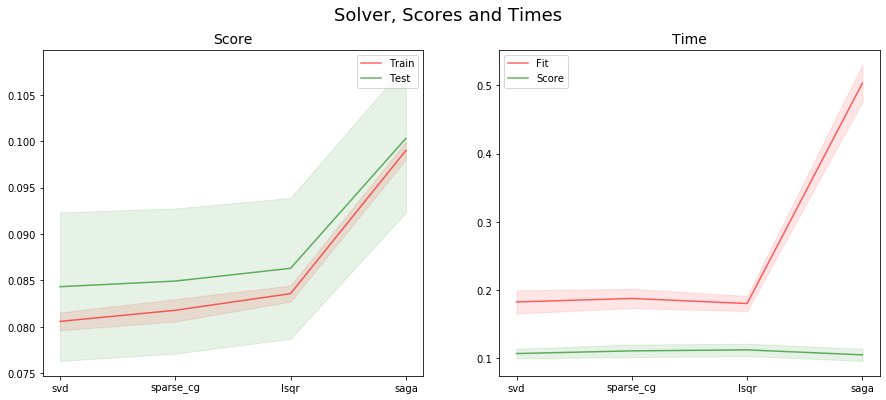

In [50]:
hyp.plot_hyperparameter(res[(res.param_ridge__alpha == 11) & (res.param_ridge__tol==0.001)], 'param_ridge__solver', 'Solver')

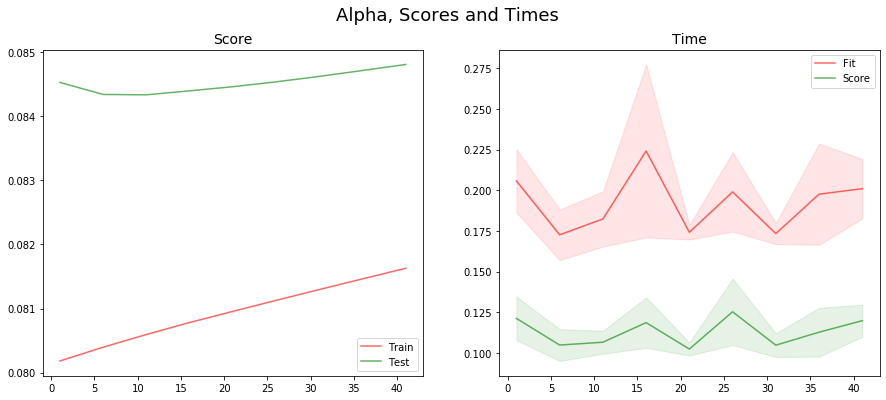

In [51]:
hyp.plot_hyperparameter(res[(res.param_ridge__solver=='svd') & (res.param_ridge__tol==0.001)], 
                        'param_ridge__alpha', 'Alpha', uncertainty=False)

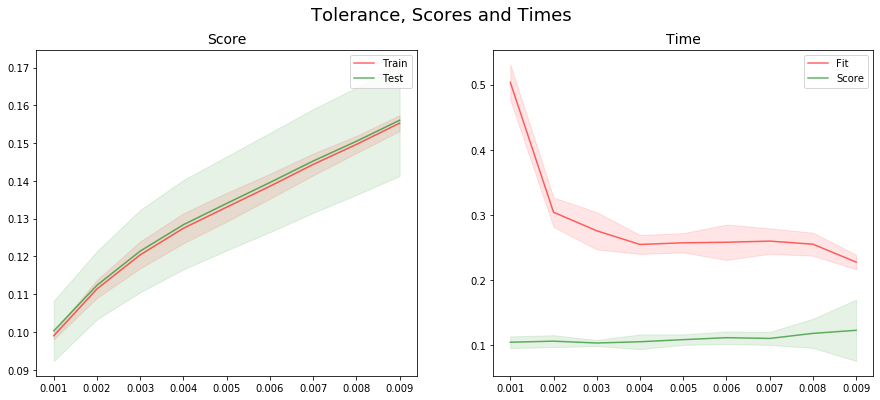

In [52]:
hyp.plot_hyperparameter(res[(res.param_ridge__solver=='saga') & (res.param_ridge__alpha==11)], 
                        'param_ridge__tol', 'Tolerance', uncertainty=True)

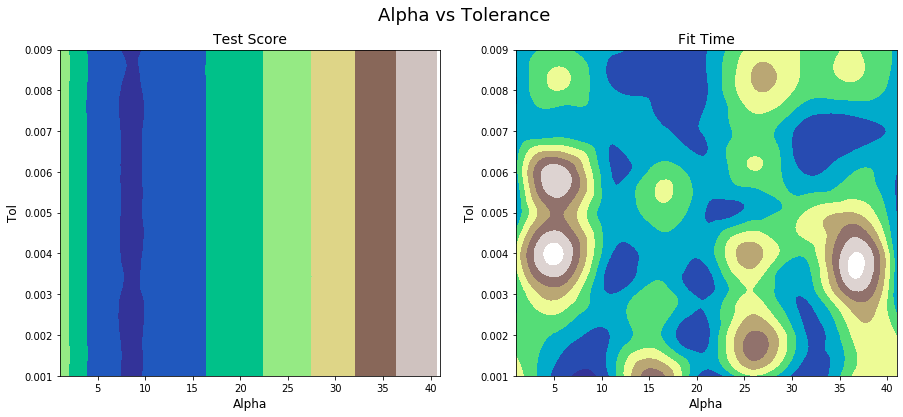

In [53]:
hyp.plot_two_hyperparms(res[(res.param_ridge__solver=='svd')], 'param_ridge__alpha', 'param_ridge__tol', 'Alpha vs Tolerance')

We finally see some more interesting patterns, some regularization seems to help but it then stops being helpful. Moreover, at the sweet spot for the hyperparameter `alpha,` we see that playing around with `tol` can improve or worsen the performance of the model. On the other hand, once that `alpha` is away from this spot, this hyperparameter stops being relevant.

We indeed see that adding a small regularizing term leads to a model that not only performs slightly better (to be fair, it is an improvement at the third digit of each metric) but, most importantly, helps the model estimating the coefficients with less uncertainty.

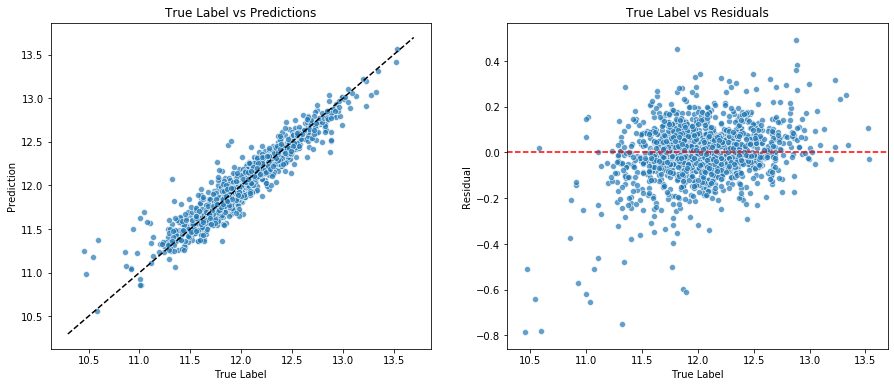

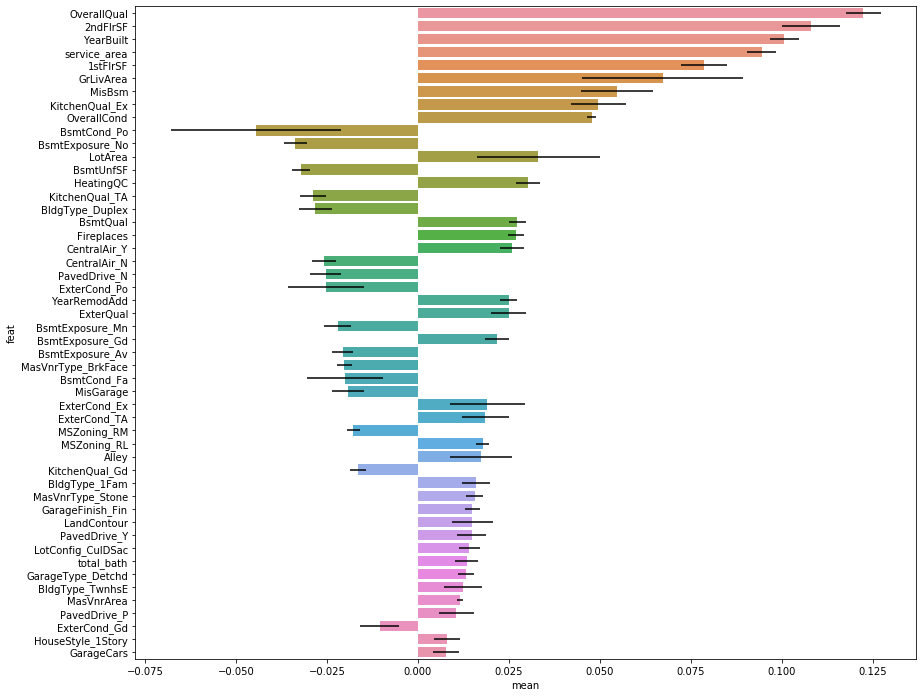

MAE: 		 0.08452
MSE: 		 0.01488
Max Error: 	 0.78325
Expl Variance: 	 0.90681


In [54]:
model = ('ridge', Ridge())
params = {'alpa':1}

make_exp(model=model, kfolds=kfolds, 
         hp=True,
         store=True, store_name=lab_book, 
         parameters=params, model_name='Ridge')

It has to be noticed that some coefficients are not as interpretable as we would like to. For example `ExterCond_Gd` has a negative coefficient, while `ExterCond_TA` has a positive one, which is not what one would expect.

If we then set the model to the optimal hypeparameters, we see an even lower uncertainty in the coefficients' estimates

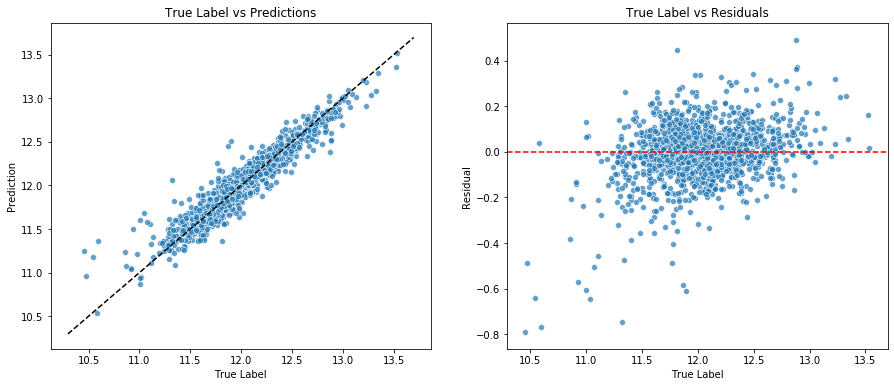

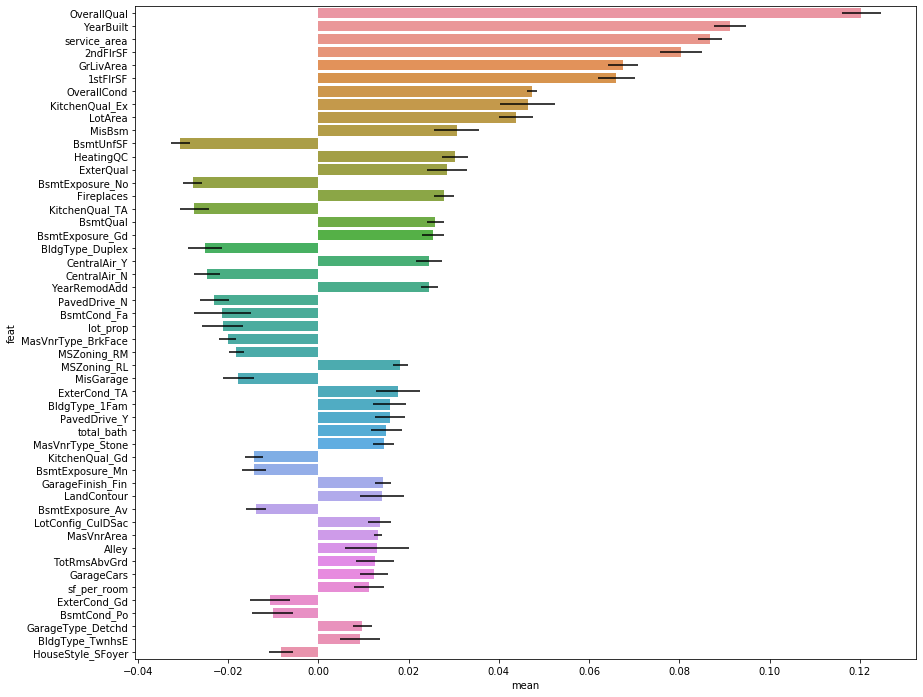

MAE: 		 0.08433
MSE: 		 0.01473
Max Error: 	 0.78917
Expl Variance: 	 0.90773


In [55]:
model = ('ridge', Ridge(alpha=11))
params = {'alpa':11}

make_exp(model=model, kfolds=kfolds, 
         hp=True,
         store=True, store_name=lab_book, 
         parameters=params, model_name='Ridge')

And bringing the regularization to an extreme value we indeed see smaller and smaller estimates with smaller and smaller uncertainties. This is indeed the effect of the $L_2$ regularization: making the coefficients smaller.

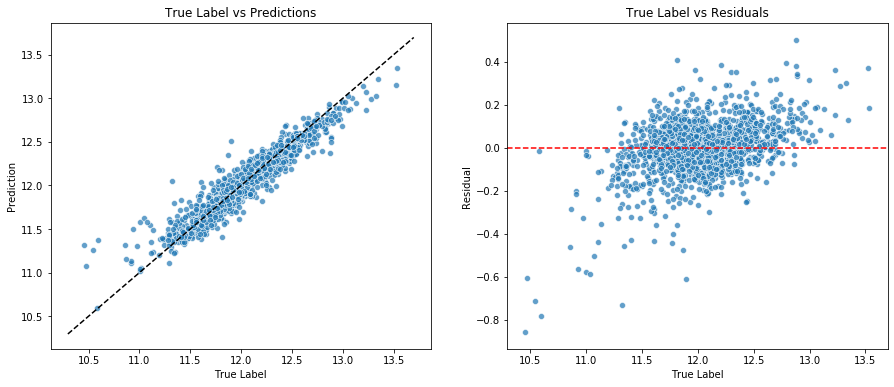

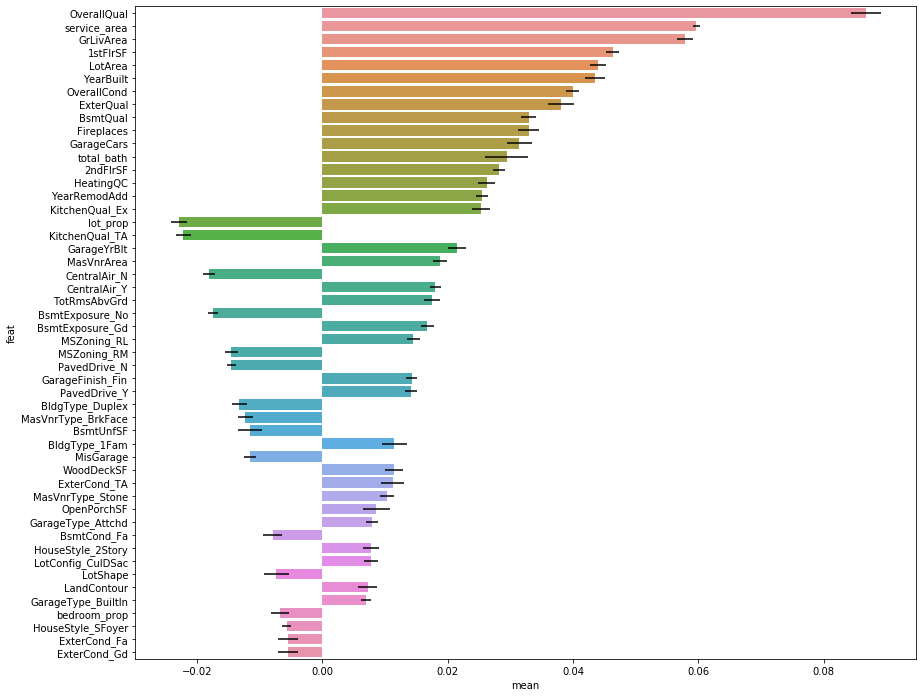

MAE: 		 0.08872
MSE: 		 0.0159
Max Error: 	 0.85645
Expl Variance: 	 0.90038


In [56]:
model = ('ridge', Ridge(alpha=200))
params = {'alpa':200}

make_exp(model=model, kfolds=kfolds, 
         hp=True,
         store=True, store_name=lab_book, 
         parameters=params, model_name='Ridge')

# Conclusion

We have seen how, with the synthetic data at hand, adding a regularizing term to our model is not generally helping. However, the regularization is becoming more important when the number of training instances is limited.

In general, the higher is the regularizing parameter, the less the model is learning the data. This can help the predictive power of a model that was previously focusing on the wrong things. The training or prediction times are not affected by the presence or the magnitude of the regularization.

The other hyperparameter (`tol`) had, at best, marginally influenced the model performance. Therefore, once that we find the right value for `alpha`, we can consider the model tuning phase as done. 

The summary of the models' results is the following

In [57]:
df = pd.read_csv(lab_book)
df = df[df.Model=='Ridge'].copy()
df.head()

Date  Model    Parameters                      Target Variables  \
24  14/02/2020  Ridge  {'alpha': 1}      10_feat_10_inf_nonoise       all   
25  14/02/2020  Ridge  {'alpha': 1}        10_feat_10_inf_noise       all   
26  14/02/2020  Ridge  {'alpha': 1}       100_feat_65_inf_noise       all   
27  14/02/2020  Ridge  {'alpha': 1}  100_feat_65_inf_noise_rank       all   
28  14/02/2020  Ridge  {'alpha': 1}      10_feat_10_inf_nonoise       all   

    N_instances         MAE            MSE    Max_error  Explained_var  
24       100000    0.001985       0.000006     0.010702       1.000000  
25       100000  159.159570   39903.463659   870.785668       0.553371  
26       100000  359.517907  202633.437357  1939.613873       0.489070  
27       100000    0.799542       1.003251     4.167692       0.265067  
28          300    0.703628       0.749763     2.785544       0.999985

In [58]:
df[df.Target == 'tar_lin_full']

Date  Model     Parameters        Target   Variables  N_instances  \
30  14/02/2020  Ridge   {'alpha': 1}  tar_lin_full         all        10000   
31  14/02/2020  Ridge   {'alpha': 1}  tar_lin_full         all          100   
32  14/02/2020  Ridge  {'alpha': 20}  tar_lin_full         all          100   
33  14/02/2020  Ridge   {'alpha': 1}  tar_lin_full  unobserved        10000   

          MAE         MSE  Max_error  Explained_var  
30   8.036092  101.710207  41.837045       0.969162  
31  19.649853  637.478339  69.144850       0.786363  
32  11.966532  223.232365  39.403148       0.935380  
33  15.701427  359.678747  59.245463       0.893580

With a target generated linearly with 100 features we observe that

* Moving from 10000 to 100 observations leads to +144% in MAE, +526% in MSE, +65% in Max Error, and -18% in explained variance. This is a lower drop with respect to the unregularized experiment of Notebook 3. 
* With a higher regularization, indeed, the change is +49% in MAE, +120% in MSE, -6% in Max Error, and -3% in explained variance
* Removing 10% of the features leads to +95% in MAE, +253% in MSE, +42% in Max Error, and -8% in explained variance.


In [59]:
df[df.Target == 'tar_lin_half']

Date  Model     Parameters        Target   Variables  N_instances  \
34  14/02/2020  Ridge   {'alpha': 1}  tar_lin_half       exact        10000   
35  14/02/2020  Ridge   {'alpha': 1}  tar_lin_half       exact          100   
36  14/02/2020  Ridge   {'alpha': 6}  tar_lin_half       exact          100   
37  14/02/2020  Ridge   {'alpha': 1}  tar_lin_half         all        10000   
38  14/02/2020  Ridge   {'alpha': 1}  tar_lin_half         all          100   
39  14/02/2020  Ridge  {'alpha': 20}  tar_lin_half         all          100   
40  14/02/2020  Ridge   {'alpha': 1}  tar_lin_half    exact-10        10000   
41  14/02/2020  Ridge   {'alpha': 1}  tar_lin_half  unobserved        10000   

          MAE          MSE  Max_error  Explained_var  
34   7.979577    99.728287  42.043022       0.995502  
35  11.344183   190.359721  37.535324       0.991300  
36   9.835243   152.513658  29.562728       0.993275  
37   7.915328    98.311896  43.724333       0.995474  
38  20.824466   700.810245  76.441017       0.966359  
39  14.053237   311.795462  45.804122       0.987550  
40  32.351790  1433.863672  94.863195       0.934475  
41  33.895429  1580.425706  97.960270       0.927546

With a target generated linearly with 50 features we observe that

* Moving from 10000 to 100 observation leads to +23% in MAE, +53% of MSE, -10% in Max Error, and nearly identical explained variance.
* If we add 50 extra features, we get a very similar perfomance.
* We again see that the regularization is helpful when the number of observations is reduced.
* On the other hand, it does not help once that some important features are missing.

In [60]:
df[df.Target == 'tar_lin_10']

Date  Model    Parameters      Target   Variables  N_instances  \
42  14/02/2020  Ridge  {'alpha': 1}  tar_lin_10       exact        10000   
43  14/02/2020  Ridge  {'alpha': 1}  tar_lin_10       exact          100   
44  14/02/2020  Ridge  {'alpha': 1}  tar_lin_10         all        10000   
45  14/02/2020  Ridge  {'alpha': 1}  tar_lin_10    exact-10        10000   
46  14/02/2020  Ridge  {'alpha': 1}  tar_lin_10  unobserved        10000   

         MAE       MSE  Max_error  Explained_var  
42  0.799805  1.007732   3.798275       0.982359  
43  0.885468  1.132924   2.720336       0.979647  
44  0.797958  0.997345   3.793749       0.982196  
45  1.271122  2.425329   5.120478       0.957237  
46  0.904340  1.278789   4.254176       0.977032

With a target generated linearly with 10 features we observe that the behavior is very similar to the unregularized model. The model is already picking up the right signal by estimating the coefficients correctly and it thus does not benefit from the presence of the regularization.

The same cannot be said about the prediction of the target variable generated non-linearly.

In [61]:
df[df.Target == 'tar_nonlin_10']

Date  Model     Parameters         Target Variables  N_instances  \
47  14/02/2020  Ridge   {'alpha': 1}  tar_nonlin_10       all        10000   
48  14/02/2020  Ridge   {'alpha': 1}  tar_nonlin_10       all          100   
49  14/02/2020  Ridge  {'alpha': 10}  tar_nonlin_10       all          100   

          MAE          MSE   Max_error  Explained_var  
47  12.732259   302.788652  183.794804       0.979708  
48  33.051810  1805.650848  135.235187       0.868821  
49  25.511648  1005.087207   85.757351       0.908127